# FrameAxis Analysis

In this notebook the process of calculating the FrameAxis values are explained, furthmore the FrameAxis values are evluated for the given datasets.

## Documentation

### 1. Microframe Design

In the following the selection of the seed words for from the eMFT is described. We select the top 40 words for each foundation-sentiment pair based on the highest propability. The seed words are selected from the eMFT dataset.

In [4]:
import pandas as pd

# load csv file from ../../data/axis/mft_raw.csv
df = pd.read_csv('../data/axis/mft_filtered.csv')

df.head()

,word,care_hlcts,fairness_hlcts,loyalty_hlcts,authority_hlcts,sanctity_hlcts,total_seen,seen_care,seen_fairness,seen_loyalty,...,fairness.virtue,loyalty.virtue,authority.virtue,sanctity.virtue,care.vice,fairness.vice,loyalty.vice,authority.vice,sanctity.vice,foundation
0,liked,0.0,1.0,5.0,2.0,2.0,107.0,17.0,21.0,29.0,...,0.047619,0.172414,0.086957,0.117647,0.0,0.0,0.0,0.0,0.0,loyalty.virtue
1,successor,2.0,2.0,9.0,2.0,2.0,192.0,35.0,43.0,46.0,...,0.046512,0.195652,0.066667,0.052632,0.0,0.0,0.0,0.0,0.0,loyalty.virtue
2,effective,15.0,9.0,4.0,11.0,10.0,487.0,100.0,109.0,80.0,...,0.082569,0.050000,0.095652,0.120482,0.0,0.0,0.0,0.0,0.0,care.virtue
3,agreement,13.0,20.0,27.0,11.0,7.0,930.0,199.0,219.0,224.0,...,0.091324,0.120536,0.079710,0.046667,0.0,0.0,0.0,0.0,0.0,loyalty.virtue
4,fit,2.0,3.0,2.0,4.0,5.0,208.0,59.0,31.0,36.0,...,0.096774,0.055556,0.083333,0.138889,0.0,0.0,0.0,0.0,0.0,sanctity.virtue


In [5]:
# Creating the 'foundation' column
df['foundation'] = df[['care_p', 'fairness_p', 'loyalty_p', 'authority_p', 'sanctity_p']].idxmax(axis=1).str.replace('_p', '')

# Extracting the highest value sentiment for each row based on 'foundation' and classifying it as 'vice' or 'virtue'
df['sentiment'] = df.apply(lambda row: 'vice' if row[row['foundation'] + '_sent'] < 0 else 'virtue', axis=1)

In [7]:
df[df["word"] == "liked"]

,word,care_hlcts,fairness_hlcts,loyalty_hlcts,authority_hlcts,sanctity_hlcts,total_seen,seen_care,seen_fairness,seen_loyalty,...,loyalty.virtue,authority.virtue,sanctity.virtue,care.vice,fairness.vice,loyalty.vice,authority.vice,sanctity.vice,foundation,sentiment
0,liked,0.0,1.0,5.0,2.0,2.0,107.0,17.0,21.0,29.0,...,0.172414,0.086957,0.117647,0.0,0.0,0.0,0.0,0.0,loyalty,virtue


In [8]:
def get_top_n_words(df, n=3):
    # Grouping by foundation and sentiment, then apply a function to get the top n words by '_p' value within each group
    grouped = df.groupby(['foundation', 'sentiment'])
    top_n_dict = {}

    for name, group in grouped:
        foundation, sentiment = name
        # Sorting the group by '_p' value associated with the foundation and slicing the top n
        top_words = group.nlargest(n, f"{foundation}_p")['word'].tolist()
        
        # Build the nested dictionary
        if foundation not in top_n_dict:
            top_n_dict[foundation] = {}
        top_n_dict[foundation][sentiment] = top_words

    return top_n_dict

# Get the top 3 words for each foundation-sentiment combination from the enlarged dataset
top_n_words = get_top_n_words(df, n=40)
top_n_words

{'authority': {'vice': ['protested',
   'rebellion',
   'protesting',
   'revenge',
   'rage',
   'violate',
   'accuse',
   'contempt',
   'intimidation',
   'refused',
   'disruption',
   'riot',
   'launched',
   'prosecuted',
   'beating',
   'protesters',
   'condemned',
   'demanding',
   'disagreed',
   'suspicion',
   'protest',
   'rebels',
   'backed',
   'perpetrators',
   'threatens',
   'terrorists',
   'criticized',
   'hostile',
   'rebel',
   'challenged',
   'questioning',
   'protests',
   'engage',
   'ignore',
   'blocking',
   'failing',
   'defenders',
   'fired',
   'lobbying',
   'decisive'],
  'virtue': ['recommended',
   'authority',
   'revive',
   'promising',
   'embrace',
   'wise',
   'charity',
   'preventing',
   'strongly',
   'loyal',
   'granted',
   'useful',
   'encouraged',
   'stable',
   'supporters',
   'strengthen',
   'convince',
   'stopping',
   'trust',
   'incentives',
   'ambitious',
   'powerful',
   'celebrated',
   'outgoing',
   'ade

In [10]:
# save the foundation_dict to a json file
import json

with open('../../data/axis/frames.json', 'w') as f:
    json.dump(top_n_words, f)


### 2. Calculate the microframes

Each microframe consists out of a set of "positive" and "negative" words. We name them seed words.

To make use of the **contextualized** word embeddings, we will use the following approach:

#### Step 1: Define Microframes

For each word within the seed words, we perform the following steps:

- Sentence Extraction: Identify all sentences in the dataset containing the given word. For instance, if the seed word is "celebrating", we find all sentences with this word.

- Word Embedding Extraction: For each identified sentence, we extract the word embedding for each word in the sentence. Additionally, if a word is tokenized into subwords, we find the embeddings for each sub-token. We also apply lemmentization to the words, to also include the different forms of the word (e.g. celebrate and celebrating should both be considered).

- Embedding Aggregation: Calculate an average word embedding for the focal word (e.g., "celebrating") by considering its embedding or the aggregate embedding of its sub-tokens within each sentence.

This process is repeated for every word listed in the seed words across all moral foundations, resulting in a comprehensive set of embeddings that represent the semantic space of each sentiment within each foundation.

#### Step 2: Aggregate Foundation-Sentiment Embeddings
After processing all words, we end up with a single embedding for each seed word. Each seed word is associated with a "positive" (virtue) or "negative" (vice) sentiment, and also associated to one of the 5 moral foundations (care/harm, fairness/cheating, loyalty/betrayal, authority/subversion and sanctity/degradation) from the eMFT (for more infos read the thesis). We need to end up with a single embedding for each foundation-sentiment. Do do this we aggregate the embeddings for each foundation-sentiment combination (e.g., "care" + "virtue" and "care" + "vice"). This aggregation results in a single representative embedding for each combination. We do this by simply averaging the embeddings for each word in the foundation-sentiment combination.

#### Step 4: Construct Microframes
The final step involves constructing the microframe for each foundation. This is achieved by subtracting the aggregated "vice" embedding from the "virtue" embedding for each foundation:

$$microframe = virtue_embedding - vice_embedding$$

> We end up with 5 microframes.

### 3. Calculate word contribution of each word to the microframe

In this step we again get the embedding for each word in each sentence (without stopwords) and calculate how each word is "leaning" towards the created microframes from "1. Define microframe".

The word contribution is calculated as follows:

```python
vf = (pos_embedding - neg_embedding).to(self.model.device)

vw = embedding.to(self.model.device)

# Calculate cosine similarity using the formula provided
cos_sim = (
    F.cosine_similarity(vw.unsqueeze(0), vf.unsqueeze(0))
    .cpu()
    .item()
)

word_dict[dimension] = cos_sim
```

The mathematically formula for the calculation of the word contribution is as follows:
$$
W = \frac{\mathbf{V_w} \cdot \mathbf{V_f} }{ \|\mathbf{V_w}\| \|\mathbf{V_f}\|}
$$


> Note: we remove the stop words AFTER we converted the sentence to embeddings, as we need the stop words to get the correct embeddings.

### 4. Calculate the FrameAxis Bias

We calculate the FrameAxis Bias by summing the word contributions for each word in each sentence in the microframe. So that we end up with a single metric for each sentence and each microframe. 

The mathematically formula for the calculation of the FrameAxis Bias is as follows:
$$
B^t_f = \frac{\sum_{w \in t} (n_wc^w_f)}{\sum_{w \in t}n_w}
$$

So each sentence need to have 1 metric for each microframe. 

### 5. Calculate the Baseline FrameAxis Bias

We calculate the Baseline FrameAxis Bias by summing the word contributions for each word in each sentence in the microframe. So that we end up with a single metric for each microframe. 

This is basically how the whole corpus is leaning towards each of the microframes.

### 6. Calculate the FrameAxis Intensity

We finish of by calculating for each sentence and each frame the FrameAxis Intensity. We do this by substracting the word contribution of each word in the sentence from the baseline FrameAxis Bias of the whole document. The difference is squared, summed and divided by the number of words in the sentence.

The mathematically formula for the calculation of the FrameAxis Intensity is as follows:
$$
I^t_f = \frac{\sum_{w \in t} (n_w(c^w_f - B^T_f)^2)}{\sum_{w \in t}n_w}
$$

## Media Frames Corpus (MFC) Dataset

Evaluation for the Media Frames Corpus (MFC). 

### Check existence of the words in the Media Frames Corpus
As described above we built the microframes out of the contextualized embeddings from the MFC dataset. To do this the seed words for the foundation-sentiment combinations need to actually appear in the dataset. To check that in the following a count over the seed words is performed.

In [6]:
immigration_path = "../../data/mfc/immigration_labeled.json"
deathpenalty_path = "../../data/mfc/deathpenalty_labeled.json"
guncontrol_path = "../../data/mfc/guncontrol_labeled.json"
samesex_path = "../../data/mfc/samesex_labeled.json"
tobacco_path = "../../data/mfc/tobacco_labeled.json"
frames_code = "../../data/mfc/codes.json"

In [7]:
# read unlabeled data
import json

# read labeled data
with open(immigration_path) as f:
    immigration = json.load(f)

with open(deathpenalty_path) as f:
    deathpenalty = json.load(f)

with open(guncontrol_path) as f:
    guncontrol = json.load(f)

with open(samesex_path) as f:
    samesex = json.load(f)

with open(tobacco_path) as f:
    tobacco = json.load(f)

# read frames
with open(frames_code) as f:
    codes = json.load(f)

In [8]:
def get_frame_name(code):
    if "." not in str(code):
        return codes[str(code) + ".2"]
    return codes[code]

def get_tone_name(code):
    if code == "17":
        return "Pro"
    elif code == "18":
        return "Neutral"
    elif code == "19":
        return "Anti"
    else:
        return codes[code]


In [9]:
# generate statistics count
print("immigration data count: ", len(immigration))
print("deathpenalty data count: ", len(deathpenalty))
print("guncontrol data count: ", len(guncontrol))
print("samesex data count: ", len(samesex))
print("tobacco data count: ", len(tobacco))

immigration data count:  6757
deathpenalty data count:  6398
guncontrol data count:  6689
samesex data count:  10583
tobacco data count:  5274


In [10]:
def process_json(json_path):
    articles = []

    # Load the JSON file
    with open(json_path) as f:
        labeled = json.load(f)
    
    # Loop through labeled data
    for idx, article in labeled.items():
        # preprocess text
        text = article["text"]

        # replace \n, \t, \r with space
        text = text.replace("\n", " ").replace("\t", " ").replace("\r", " ")

        articles.append(text)
    
    return articles

# Call the function for each JSON object
immigration_articles = process_json(immigration_path)
deathpenalty_articles = process_json(deathpenalty_path)
guncontrol_articles = process_json(guncontrol_path)
samesex_articles = process_json(samesex_path)
tobacco_articles = process_json(tobacco_path)

#### Use Counter for each frame and word

In [11]:
import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Download the WordNet data only the first time you run this
nltk.download('wordnet')

def count_tf_comparison(articles):
    lemmatizer = WordNetLemmatizer()
    
    # Initialize counters
    original_words_freq = Counter()
    lemmatized_words_freq = Counter()
    
    # Process each article
    for article in articles:
        tokens = article.split()
        
        # Update the original words frequency
        original_words_freq.update(tokens)
        
        # Lemmatize and update the lemmatized words frequency
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        lemmatized_words_freq.update(lemmatized_tokens)
    
    return original_words_freq, lemmatized_words_freq

original_freq, lemmatized_freq = count_tf_comparison(immigration_articles)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
len(original_freq), len(lemmatized_freq)

(108860, 105526)

#### Now check how often each of the eMFT words appear in the Media Frames Corpus

In [13]:
# use foundation_dict
word_count = []
for domain, values in top_n_words.items():
    print(domain)
    for value_type in ["virtue", "vice"]:
        print("  ", value_type)
        for word in values[value_type]:
            print("    ", word, lemmatized_freq[word])
            word_count.append((word, lemmatized_freq[word]))

NameError: name 'top_n_words' is not defined

In [ ]:
# statistics for word_count
print("AVG word count: ", sum([count for _, count in word_count]) / len(word_count))
print("MAX word count: ", max([count for _, count in word_count]))
print("MIN word count: ", min([count for _, count in word_count]))

AVG word count:  81.6159793814433
MAX word count:  5558
MIN word count:  0


### Analyse the frameaxis 

I used the generated list of words above to calculate for the whole labeled MFC dataset the frameaxis value (bias and intensity). Now I want to analyse if the value show some pattern in connection to the primary frame of the articles.

In [48]:
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import io
import torch

In [49]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [50]:
# load frameaxis data
with open('../../data/frameaxis/mfc/frameaxis_mft.pkl', 'rb') as f:
    df_frameaxis = CPU_Unpickler(f).load()

# load mfc data
df_mfc = pd.DataFrame(json.load(open("../../data/mfc/immigration_labeled_preprocessed.json")))

# load raw articles to get tone
imm_df = pd.DataFrame(json.load(open(immigration_path)))

# prepare immigration articles
imm_df = imm_df.T

df_mfc.set_index('article_id', inplace=True)
result_df = df_mfc.join(imm_df['primary_tone'], how='left')

# reset index
df_frameaxis.reset_index(drop=True, inplace=True)
result_df.reset_index(drop=True, inplace=True)

# merge frameaxis_df and mfc_df column wise on the basis of row num/index
df_merged = pd.concat([df_frameaxis, result_df], axis=1)

drop_columns = ['Capacity and Resources',
       'Crime and Punishment', 'Cultural Identity', 'Economic',
       'External Regulation and Reputation', 'Fairness and Equality',
       'Health and Safety', 'Legality, Constitutionality, Jurisdiction',
       'Morality', 'Other', 'Policy Prescription and Evaluation', 'Political',
       'Public Sentiment', 'Quality of Life', 'Security and Defense',]

df_merged = df_merged.drop(columns=drop_columns)

df = df_merged

# remove 18 from primary_tone
# df = df[df['primary_tone'] != 18]

df['primary_tone'] = pd.Categorical(df['primary_tone'], categories=[17, 18, 19], ordered=True)

# rename the primary_tone column to tone
df.rename(columns={"primary_tone": "tone"}, inplace=True)

# rename all 17 to pro, 18 to neutral, 19 to anti in the tone column
df['tone'] = df['tone'].apply(lambda x: "pro" if x == 17 else "neutral" if x == 18 else "anti" if x == 19 else "nan")

In [51]:
for col in ['authority_bias', 'authority_intensity', 'care_bias',
       'care_intensity', 'fairness_bias', 'fairness_intensity', 'loyalty_bias',
       'loyalty_intensity', 'sanctity_bias', 'sanctity_intensity']:
    if isinstance(df[col][0], torch.Tensor):
        df[col] = df[col].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)


In [52]:
bias_columns = [
    "care_bias",
    "loyalty_bias",
    "authority_bias",
    "fairness_bias",
    "sanctity_bias",
]

intensity_columns = [
    "care_intensity",
    "loyalty_intensity",
    "authority_intensity",
    "fairness_intensity",
    "sanctity_intensity",
]

In [53]:
df['frame_tone'] = df['document_frame'] + " - " + df['tone'].astype(str)

In [54]:
df_agg = df.groupby('article_id').agg({
    'authority_bias': 'mean',
    'authority_intensity': 'mean',
    'care_bias': 'mean',
    'care_intensity': 'mean',
    'fairness_bias': 'mean',
    'fairness_intensity': 'mean',
    'loyalty_bias': 'mean',
    'loyalty_intensity': 'mean',
    'sanctity_bias': 'mean',
    'sanctity_intensity': 'mean',
    'text': ' '.join,  # Append the values in 'text' column
    'document_frame': 'first',  # Take the first, assuming all are the same
    'tone': 'first',  # Take the first, assuming all are the same
    'frame_tone': 'first'  # Take the first, assuming all are the same
}).reset_index()

In [55]:
df = df_agg

In [56]:
df["document_frame"].value_counts()

document_frame
Political                                    969
Legality, Constitutionality, Jurisdiction    957
Crime and Punishment                         803
Cultural Identity                            556
Policy Presecription and Evaluation          473
Economic                                     414
Quality of Life                              410
Security and Defense                         286
Public Sentiment                             243
Health and Safety                            239
Capacity and Resources                       210
Fairness and Equality                        155
External Regulation and Reputation           132
Morality                                      76
Other                                          9
Name: count, dtype: int64

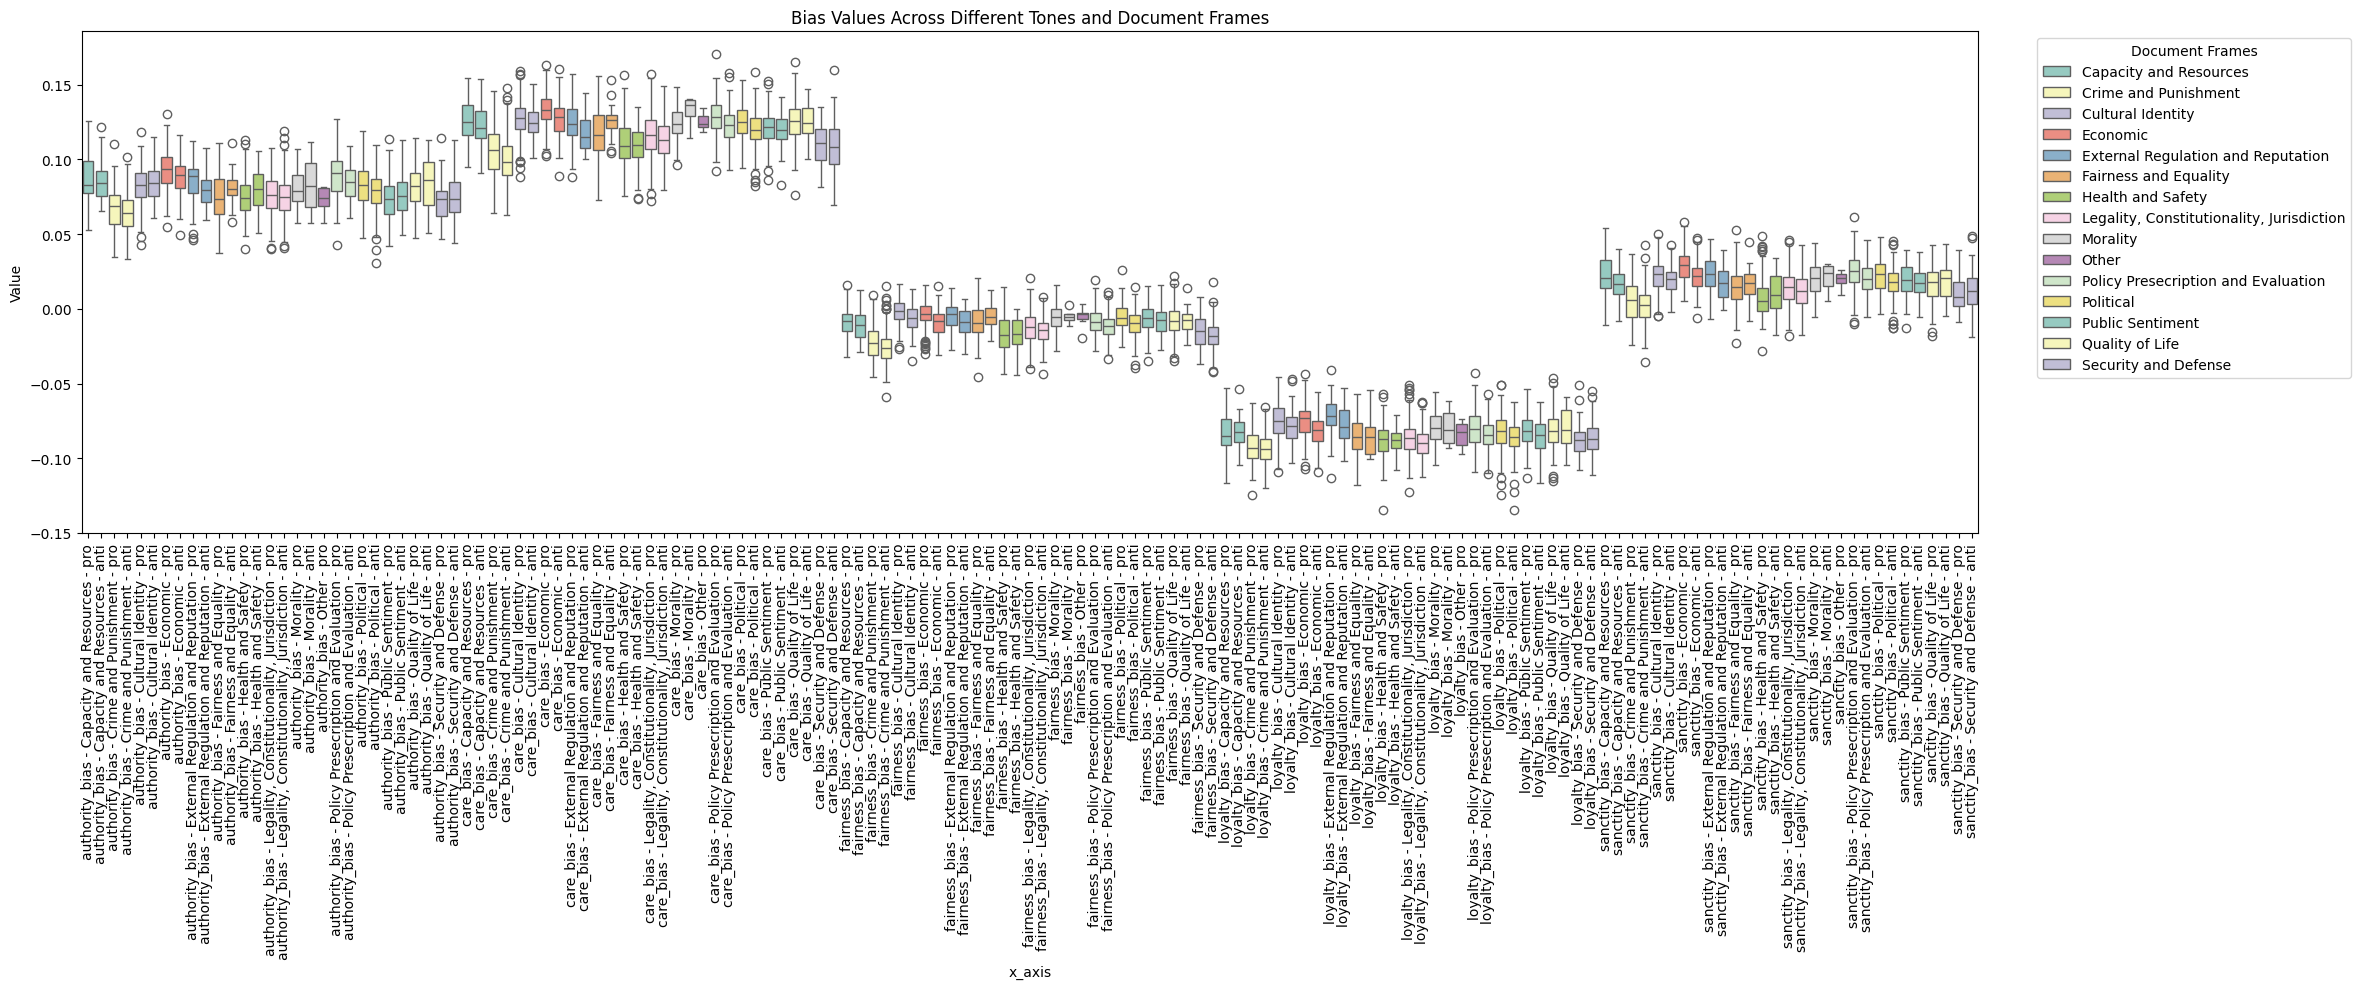

In [57]:
def plot_bias_foundations(df, foundations, tones=['pro', 'neutral', 'anti']):

    # Filtering the DataFrame for the tones we are interested in
    df = df[df['tone'].isin(tones)]

    # Melting the DataFrame for the bias values we are interested in
    bias_columns = foundations
    melted_bias = df.melt(id_vars=[ 'document_frame', 'tone'], value_vars=bias_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_bias.dropna(inplace=True)

    # Creating a composite key for plotting, which combines the 'Metric', 'document_frame', and 'tone'
    melted_bias['x_axis'] = melted_bias.apply(
        lambda x: f"{x['Metric']} - {x['document_frame']} - {x['tone']}", axis=1
    )

    # Sort the melted DataFrame to define the order of boxplots
    melted_bias.sort_values(by=['Metric', 'document_frame', 'tone'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_bias['x_axis'].unique()

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Create a boxplot and map colors to 'document_frame'
    boxplot = sns.boxplot(x='x_axis', y='Value', data=melted_bias, hue='document_frame', palette='Set3', order=x_ticks_order, dodge=False)

    plt.title('Bias Values Across Different Tones and Document Frames')
    plt.xticks(rotation=90)  # Rotating the x-ticks to prevent overlap due to the long names
    plt.tight_layout()
    
    # Adding legend
    handles, labels = boxplot.get_legend_handles_labels()
    plt.legend(handles, labels, bbox_to_anchor=(1.20, 1), title="Document Frames", loc='upper right')
    
    plt.show()


# 'authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'
plot_bias_foundations(df,  ['authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'], tones=['pro', 'anti'])

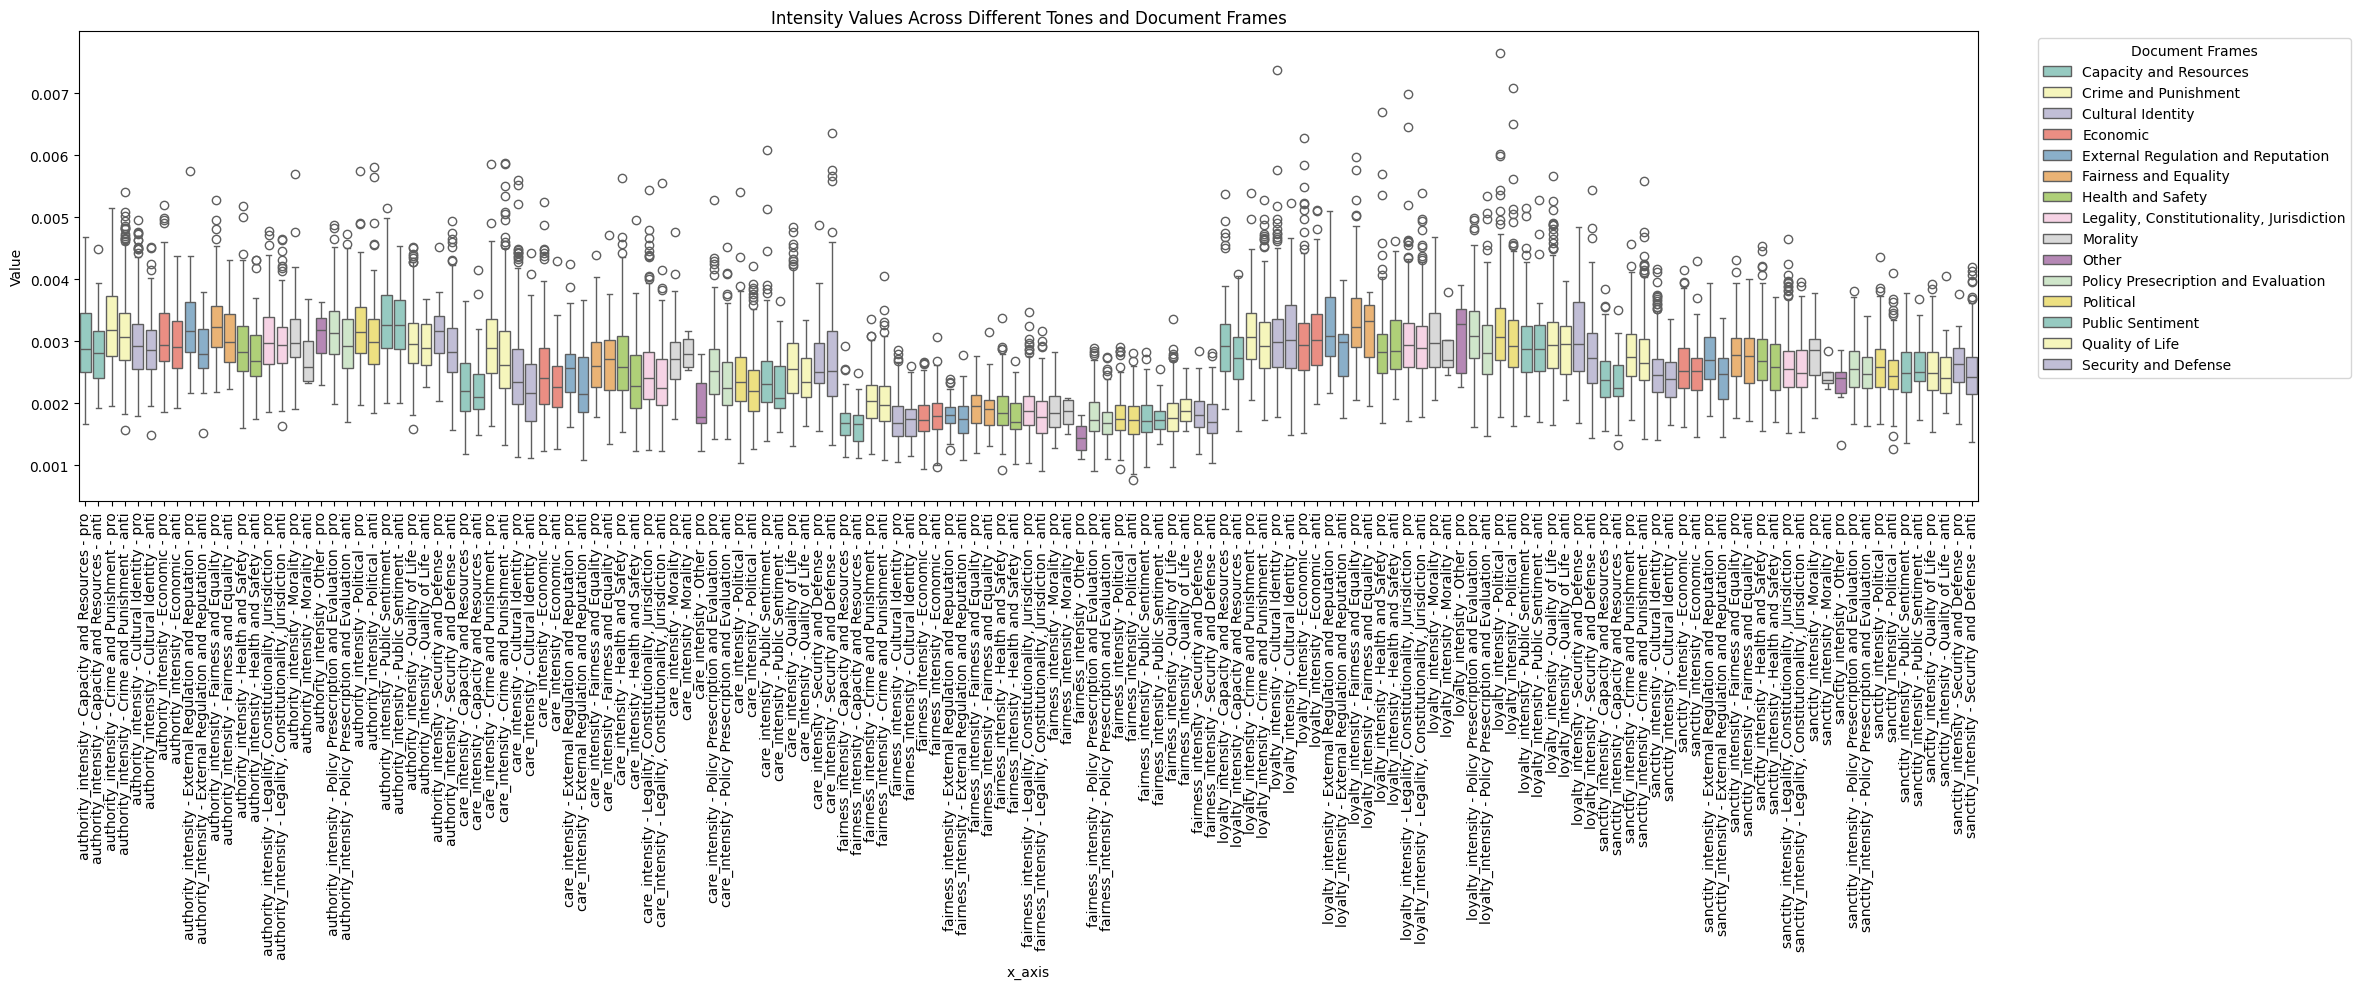

In [58]:
def plot_intensity_foundations(df, foundations, tones=['pro', 'neutral', 'anti']):
    # Filtering the DataFrame for the tones we are interested in
    df = df[df['tone'].isin(tones)]

    # Melting the DataFrame for the bias values we are interested in
    bias_columns = foundations
    melted_bias = df.melt(id_vars=['article_id', 'document_frame', 'tone', 'text'], value_vars=bias_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_bias.dropna(inplace=True)

    # Creating a composite key for plotting, which combines the 'Metric', 'document_frame', and 'tone'
    melted_bias['x_axis'] = melted_bias.apply(
        lambda x: f"{x['Metric']} - {x['document_frame']} - {x['tone']}", axis=1
    )

    # Sort the melted DataFrame to define the order of boxplots
    melted_bias.sort_values(by=['Metric', 'document_frame', 'tone'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_bias['x_axis'].unique()

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Create a boxplot and map colors to 'document_frame'
    boxplot = sns.boxplot(x='x_axis', y='Value', data=melted_bias, hue='document_frame', palette='Set3', order=x_ticks_order, dodge=False)

    plt.title('Intensity Values Across Different Tones and Document Frames')
    plt.xticks(rotation=90)  # Rotating the x-ticks to prevent overlap due to the long names
    plt.tight_layout()
    
    # Adding legend
    handles, labels = boxplot.get_legend_handles_labels()
    plt.legend(handles, labels, bbox_to_anchor=(1.20, 1), title="Document Frames", loc='upper right')
    
    plt.show()


# 'authority_intensity', 'care_intensity', 'fairness_intensity', 'loyalty_intensity', 'sanctity_intensity'
plot_intensity_foundations(df,  ['authority_intensity', 'care_intensity', 'fairness_intensity', 'loyalty_intensity', 'sanctity_intensity'], tones=['pro', 'anti'])

C:\Users\elias\AppData\Local\Temp\ipykernel_28424\2554789607.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='x_axis', y='Value', data=melted_bias, palette='Set3', order=x_ticks_order)


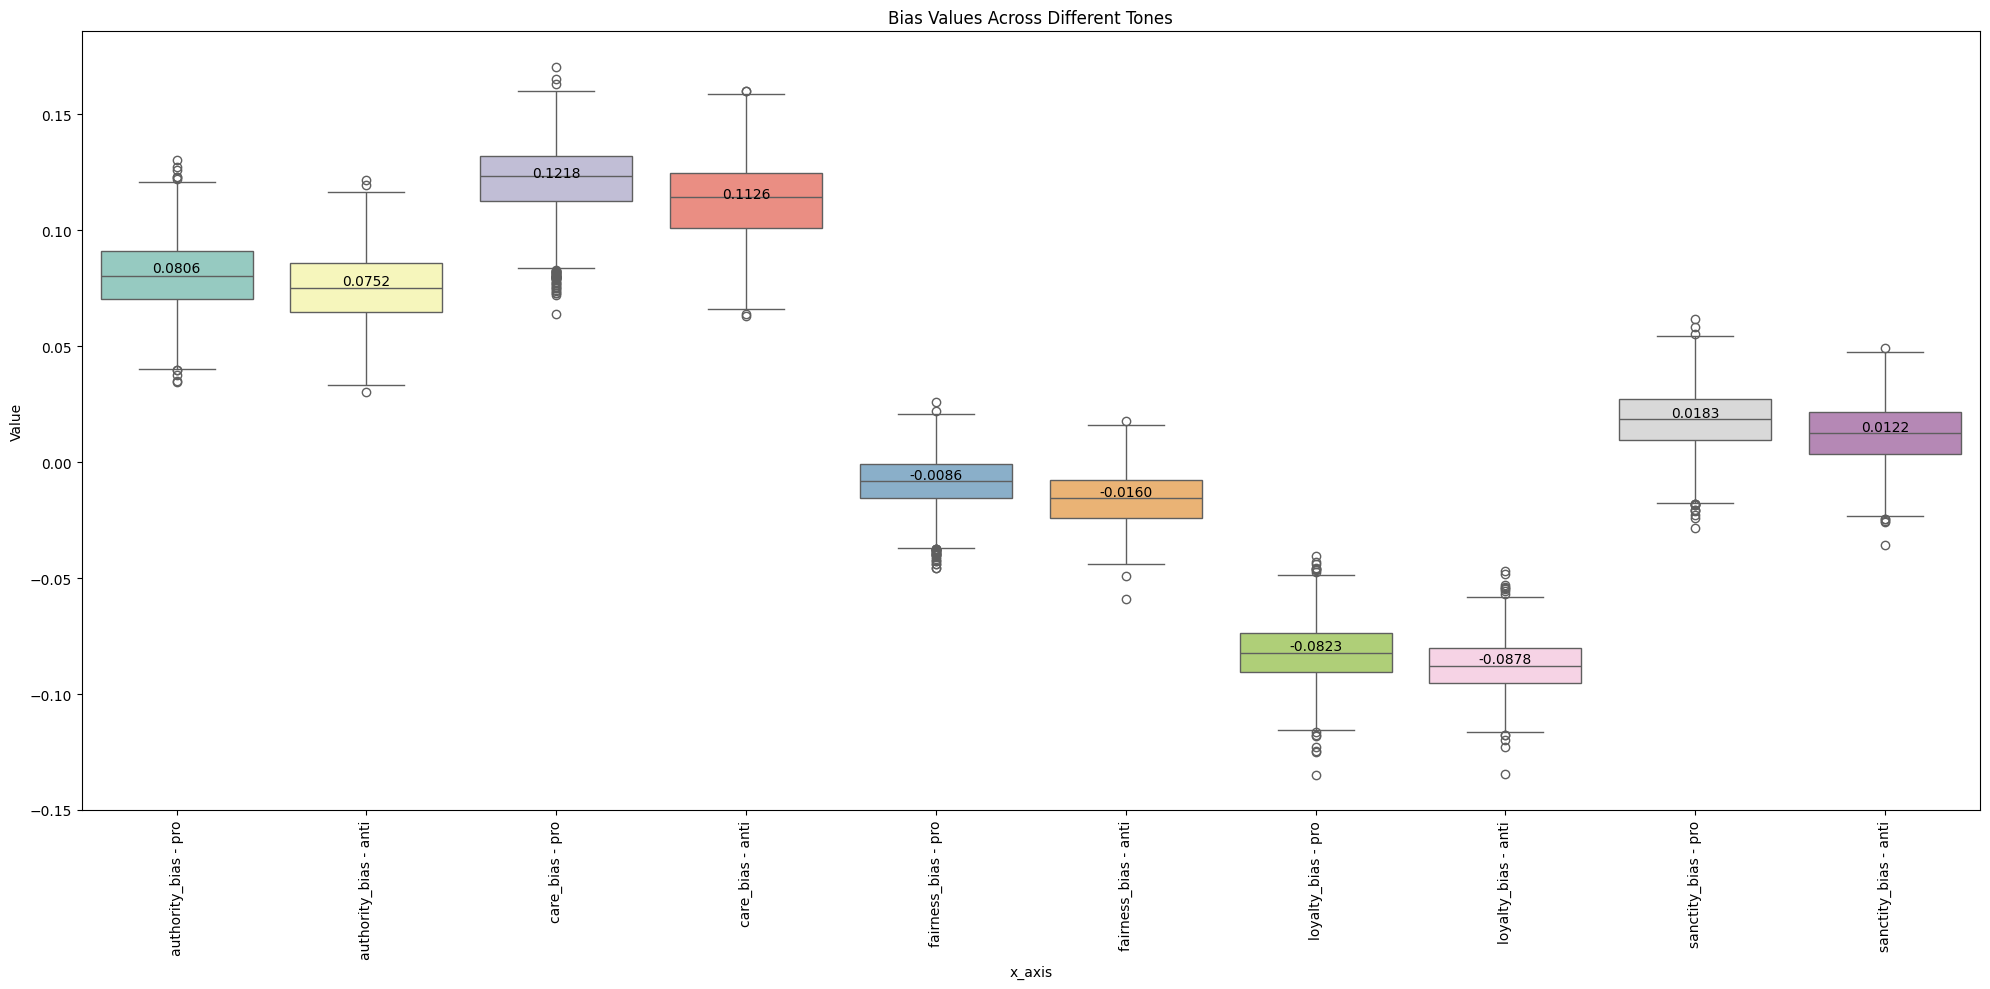

In [59]:
def plot_bias_foundations(df, foundations, tones=['pro', 'neutral', 'anti']):
    # Filtering the DataFrame for the tones we are interested in
    df = df[df['tone'].isin(tones)]

    # Melting the DataFrame for the bias values we are interested in
    bias_columns = foundations
    melted_bias = df.melt(id_vars=['tone'], value_vars=bias_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_bias.dropna(inplace=True)

    # Creating a composite key for plotting, which combines the 'Metric' and 'tone'
    melted_bias['x_axis'] = melted_bias.apply(
        lambda x: f"{x['Metric']} - {x['tone']}", axis=1
    )

    # Sort the melted DataFrame to define the order of boxplots
    melted_bias.sort_values(by=['Metric', 'tone'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_bias['x_axis'].unique()

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Create a boxplot
    sns.boxplot(x='x_axis', y='Value', data=melted_bias, palette='Set3', order=x_ticks_order)

    plt.title('Bias Values Across Different Tones')
    plt.xticks(rotation=90)  # Rotating the x-ticks to prevent overlap due to the long names

    # Calculating and annotating the mean for each group in the boxplot
    for i, group in enumerate(x_ticks_order):
        # Getting the mean of the values in the current group
        group_data = melted_bias[melted_bias['x_axis'] == group]['Value']
        mean_val = group_data.mean()
        
        # Annotating the mean
        plt.text(i, mean_val, f'{mean_val:.4f}', color='black', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


# 'authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'
plot_bias_foundations(df, ['authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'], tones=['pro', 'anti'])

### Plot Bias and Intensity for each foundation WITHOUT tone

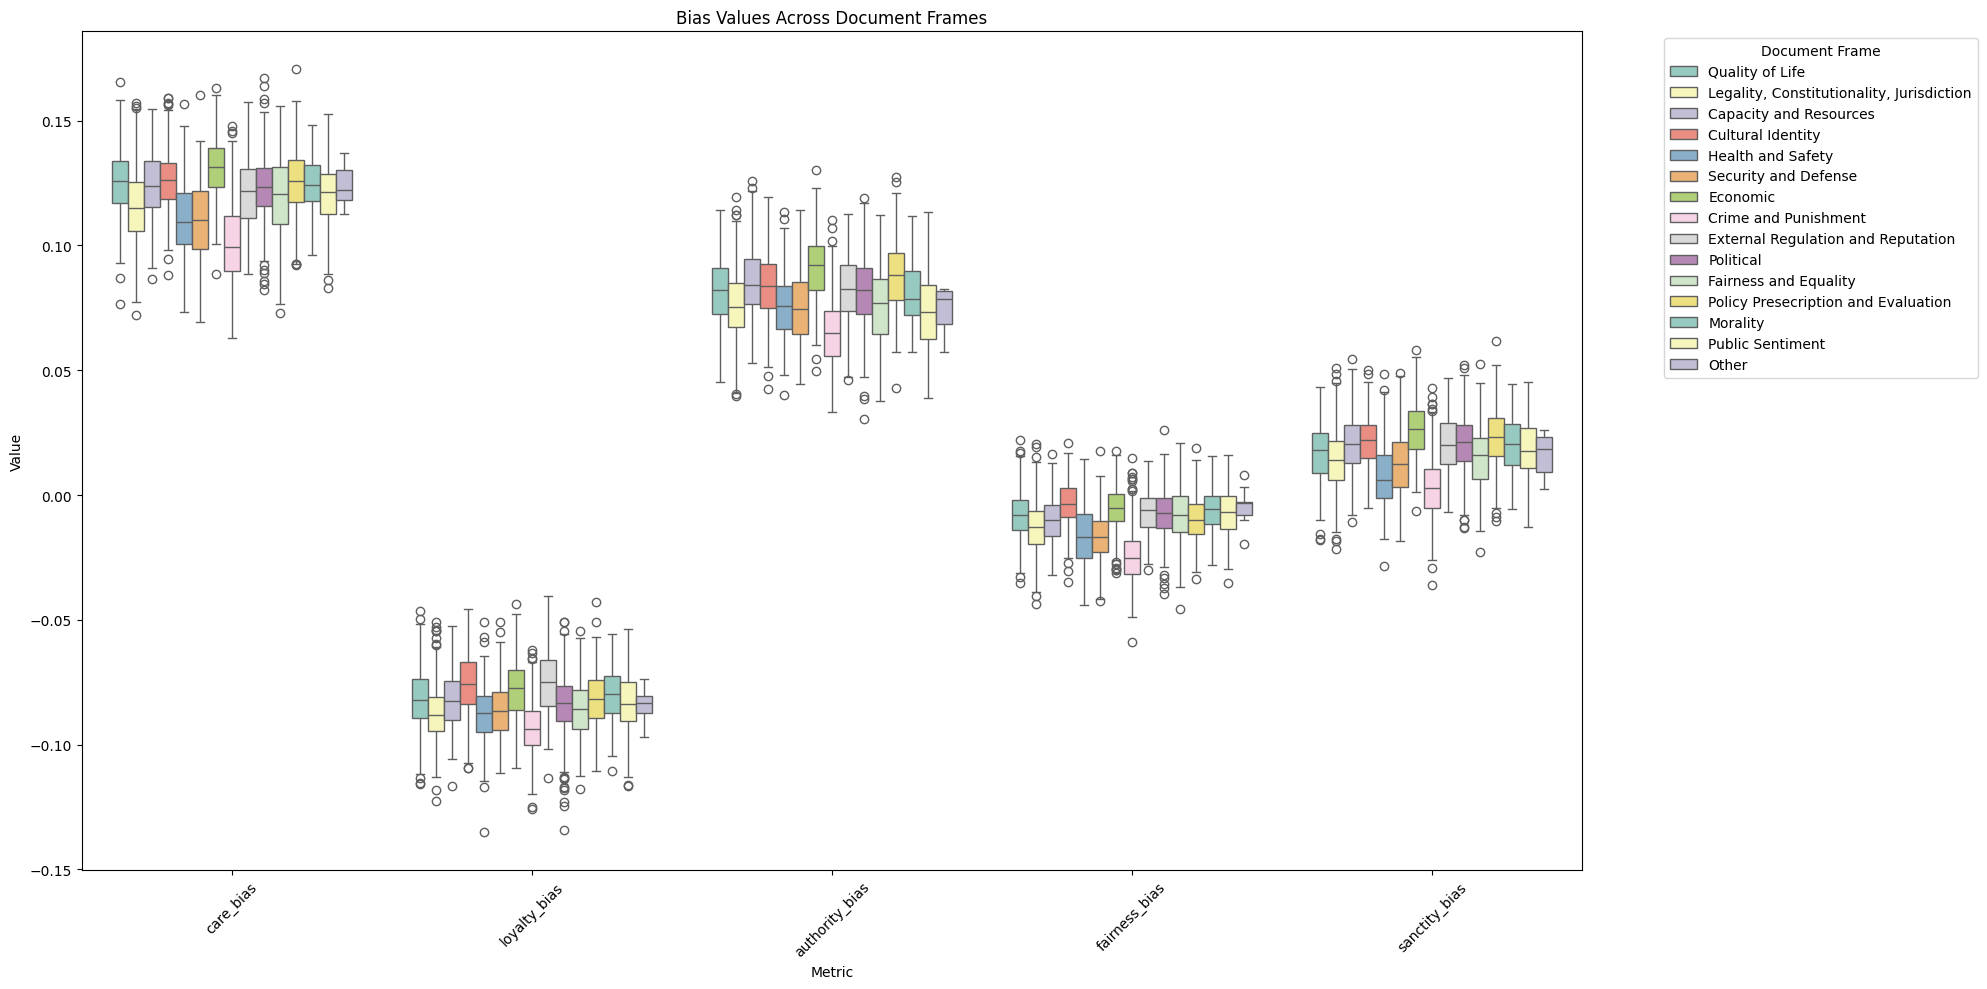

In [60]:
melted_bias = df.melt(id_vars=['document_frame'], value_vars=bias_columns, 
                                var_name='Metric', value_name='Value')
melted_bias['Type'] = 'Bias'

# Combining bias and intensity data
combined_data = pd.concat([melted_bias])

# Plotting
plt.figure(figsize=(20, 10))
sns.boxplot(x='Metric', y='Value', hue='document_frame', data=combined_data, palette='Set3')
plt.title('Bias Values Across Document Frames')
plt.xticks(rotation=45)
plt.legend(title='Document Frame', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

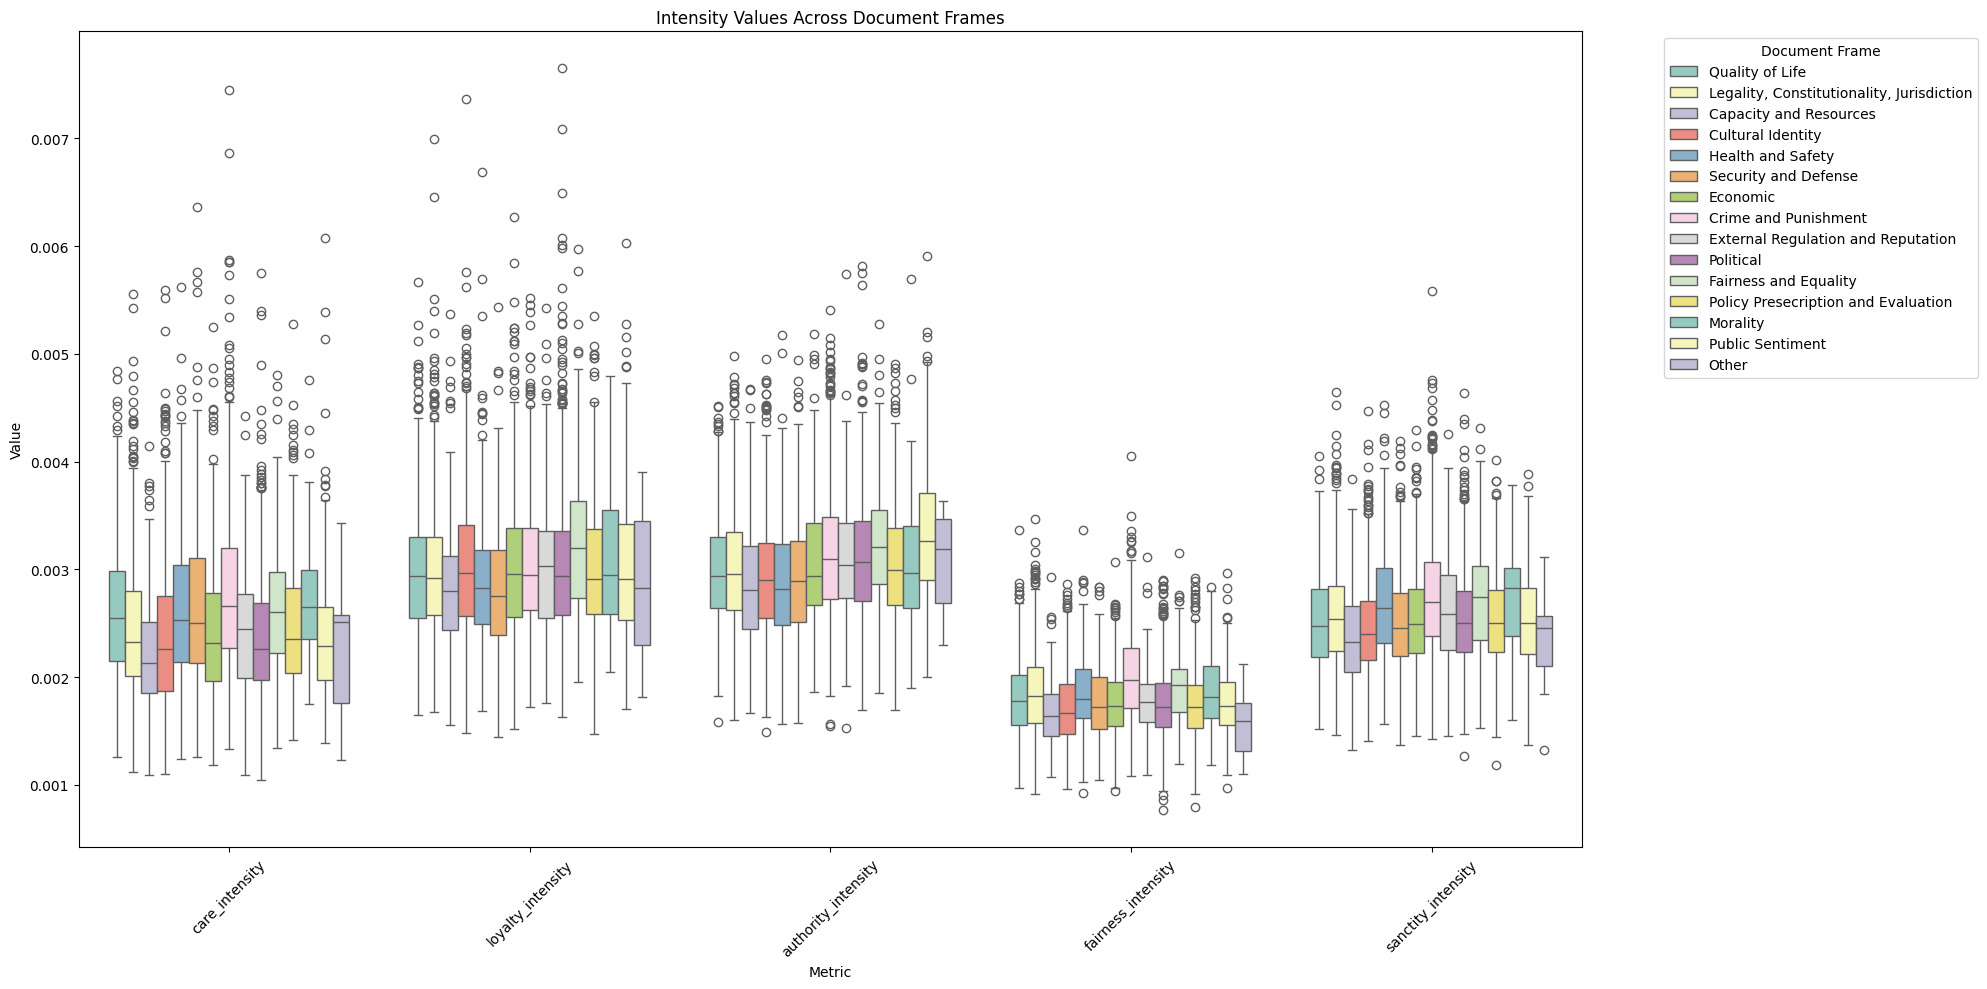

In [61]:
melted_intensity = df.melt(id_vars=['document_frame'], value_vars=intensity_columns, 
                                     var_name='Metric', value_name='Value')
melted_intensity['Type'] = 'Intensity'

# Combining bias and intensity data
combined_data = pd.concat([melted_intensity])

# Plotting
plt.figure(figsize=(20, 10))
sns.boxplot(x='Metric', y='Value', hue='document_frame', data=combined_data, palette='Set3')
plt.title('Intensity Values Across Document Frames')
plt.xticks(rotation=45)
plt.legend(title='Document Frame', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Plot Bias & Intensity for single foundation WITHOUT tone

C:\Users\elias\AppData\Local\Temp\ipykernel_28424\2887052724.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_bias', data=df, palette='Set2')


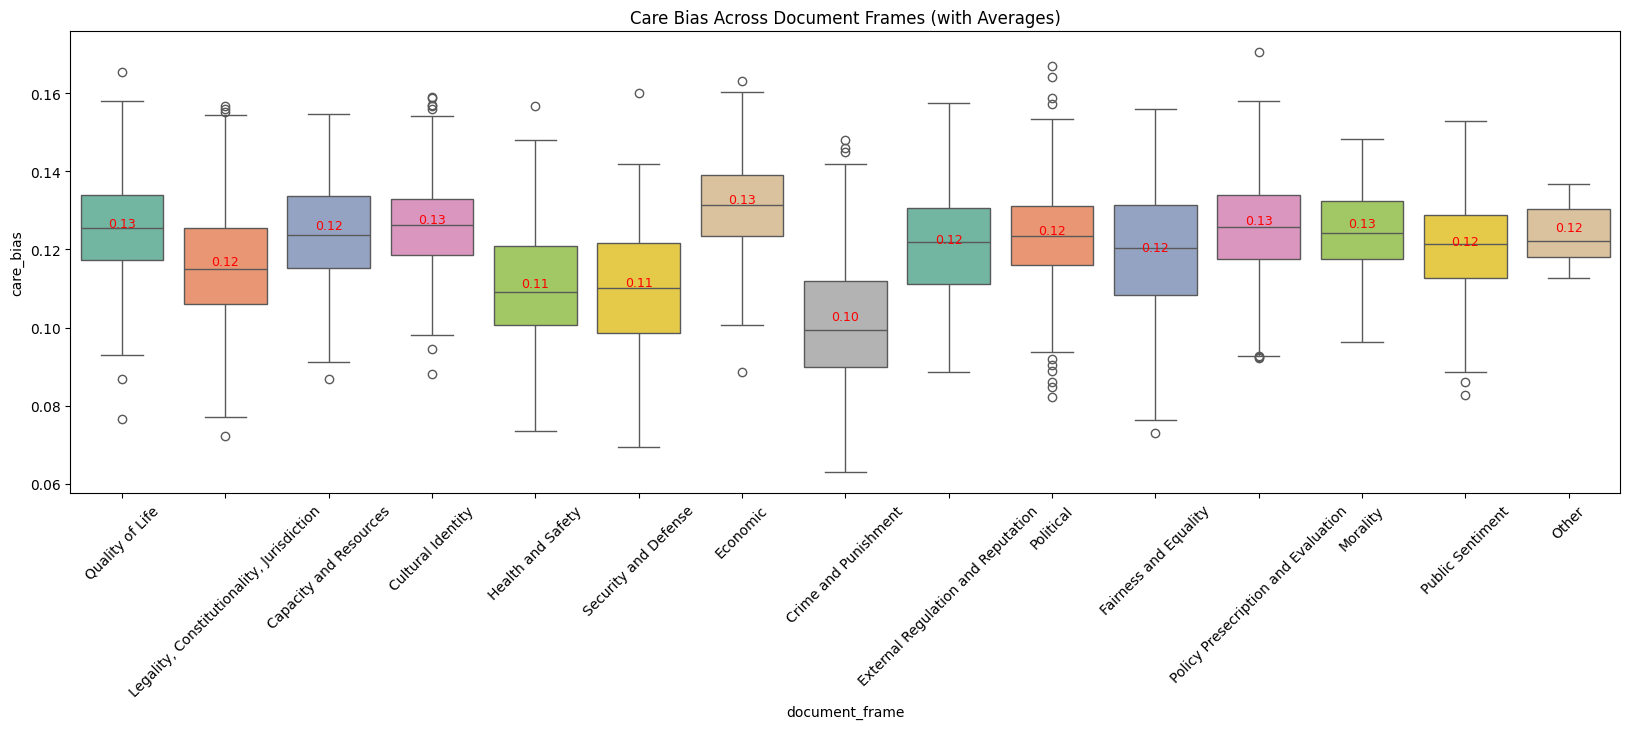

C:\Users\elias\AppData\Local\Temp\ipykernel_28424\2887052724.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_bias', data=df, palette='Set2')


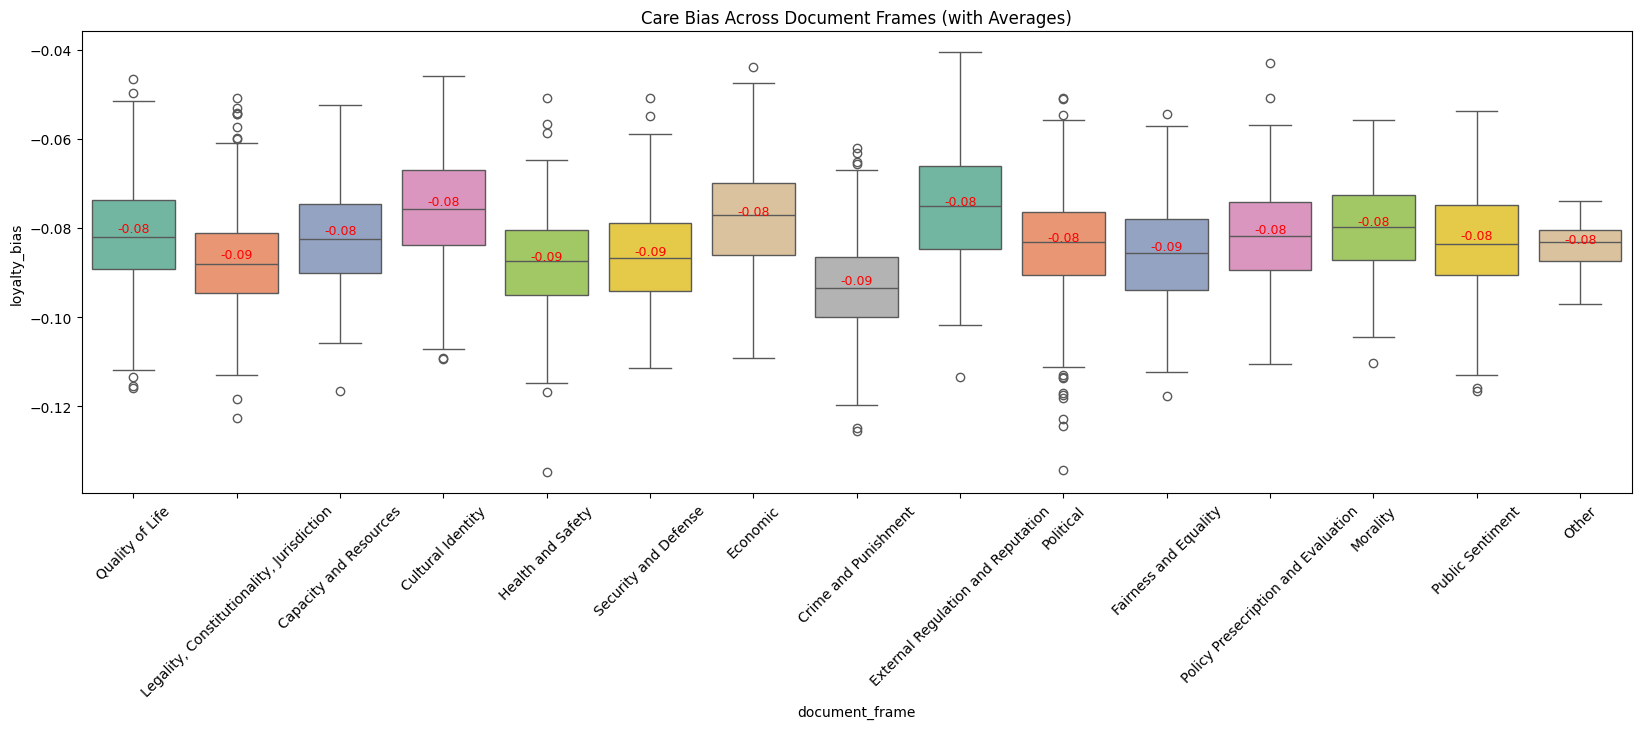

C:\Users\elias\AppData\Local\Temp\ipykernel_28424\2887052724.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_bias', data=df, palette='Set2')


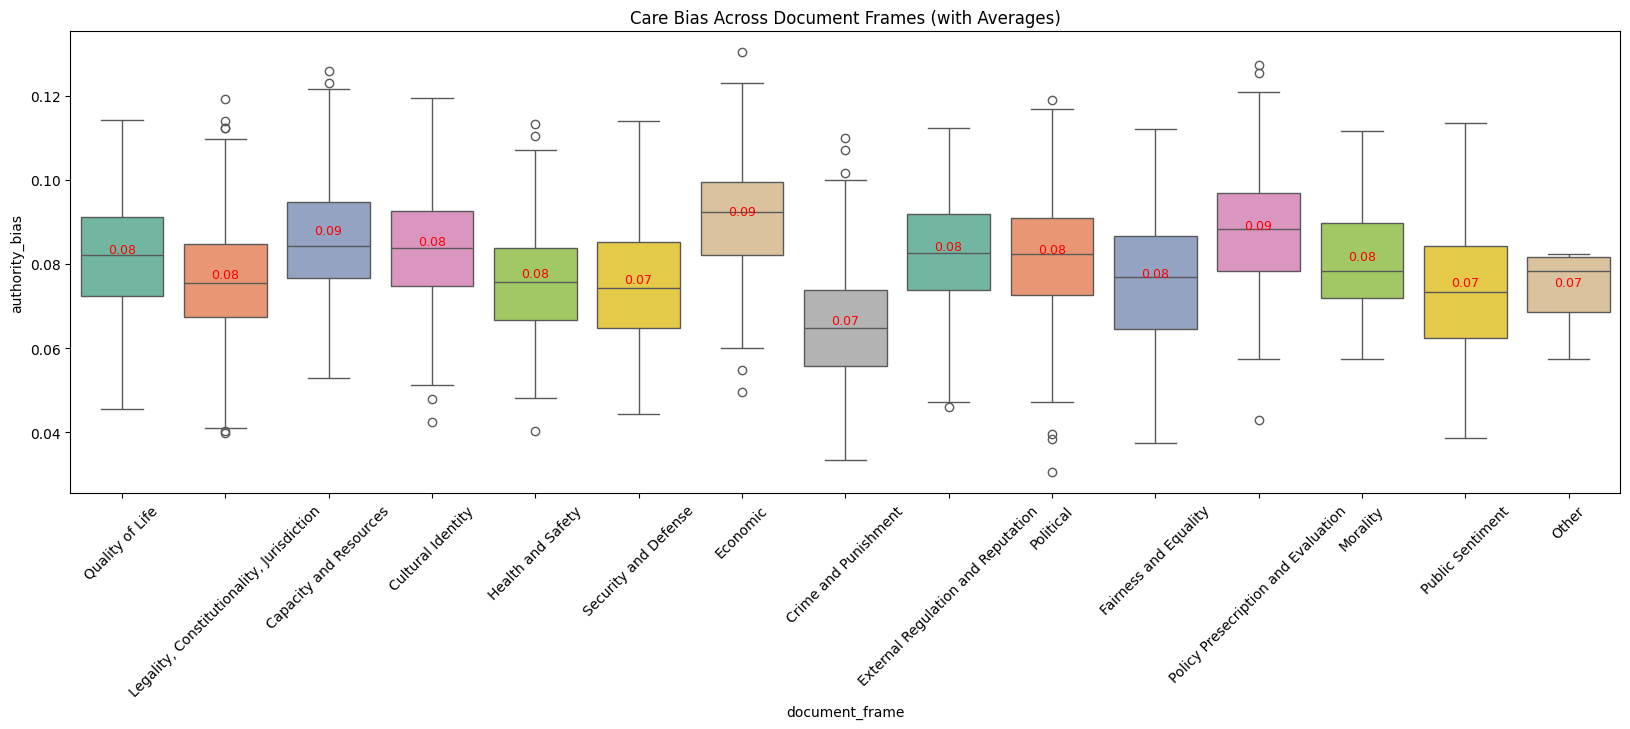

C:\Users\elias\AppData\Local\Temp\ipykernel_28424\2887052724.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_bias', data=df, palette='Set2')


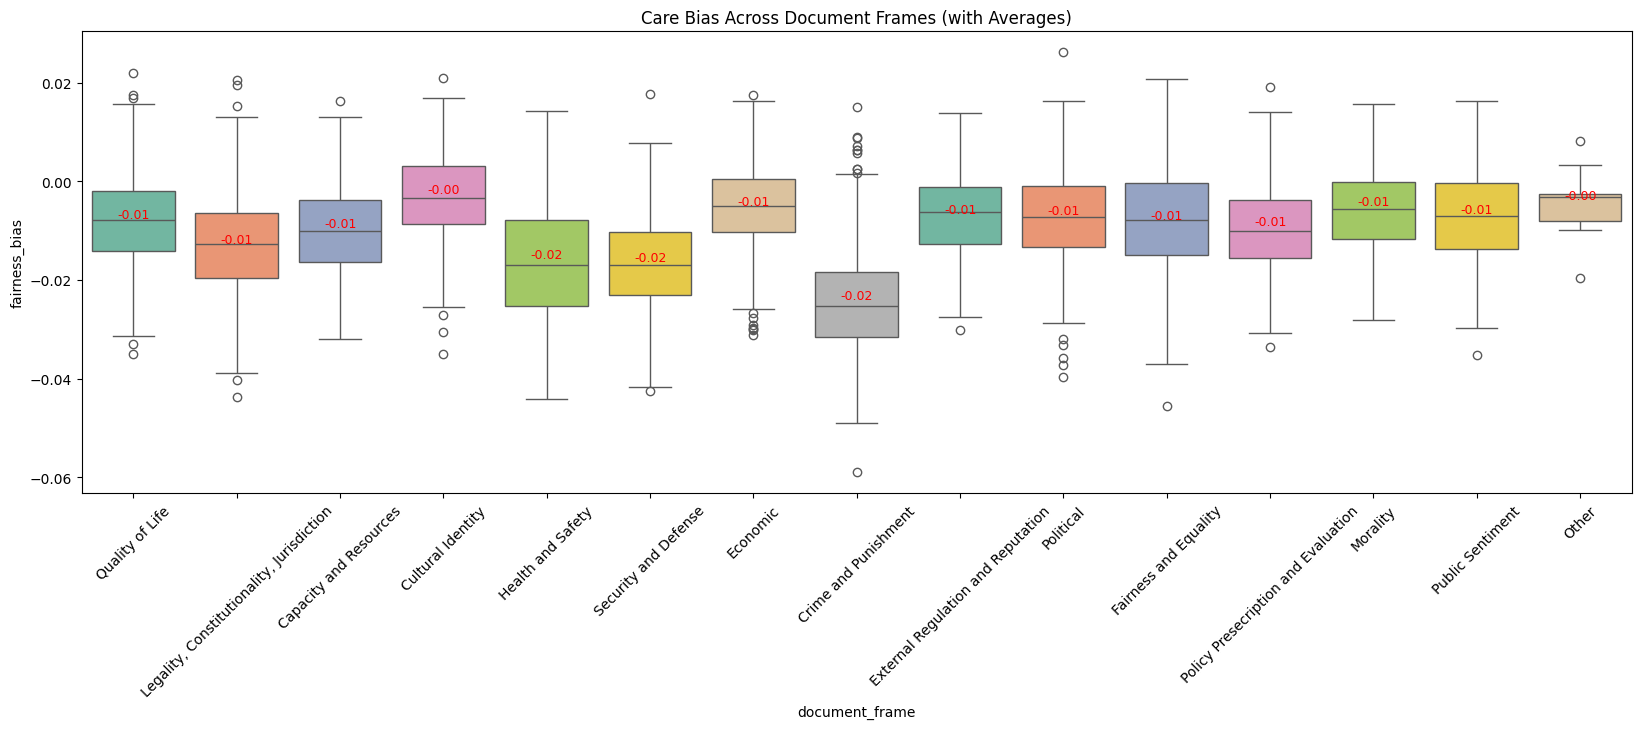

C:\Users\elias\AppData\Local\Temp\ipykernel_28424\2887052724.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_bias', data=df, palette='Set2')


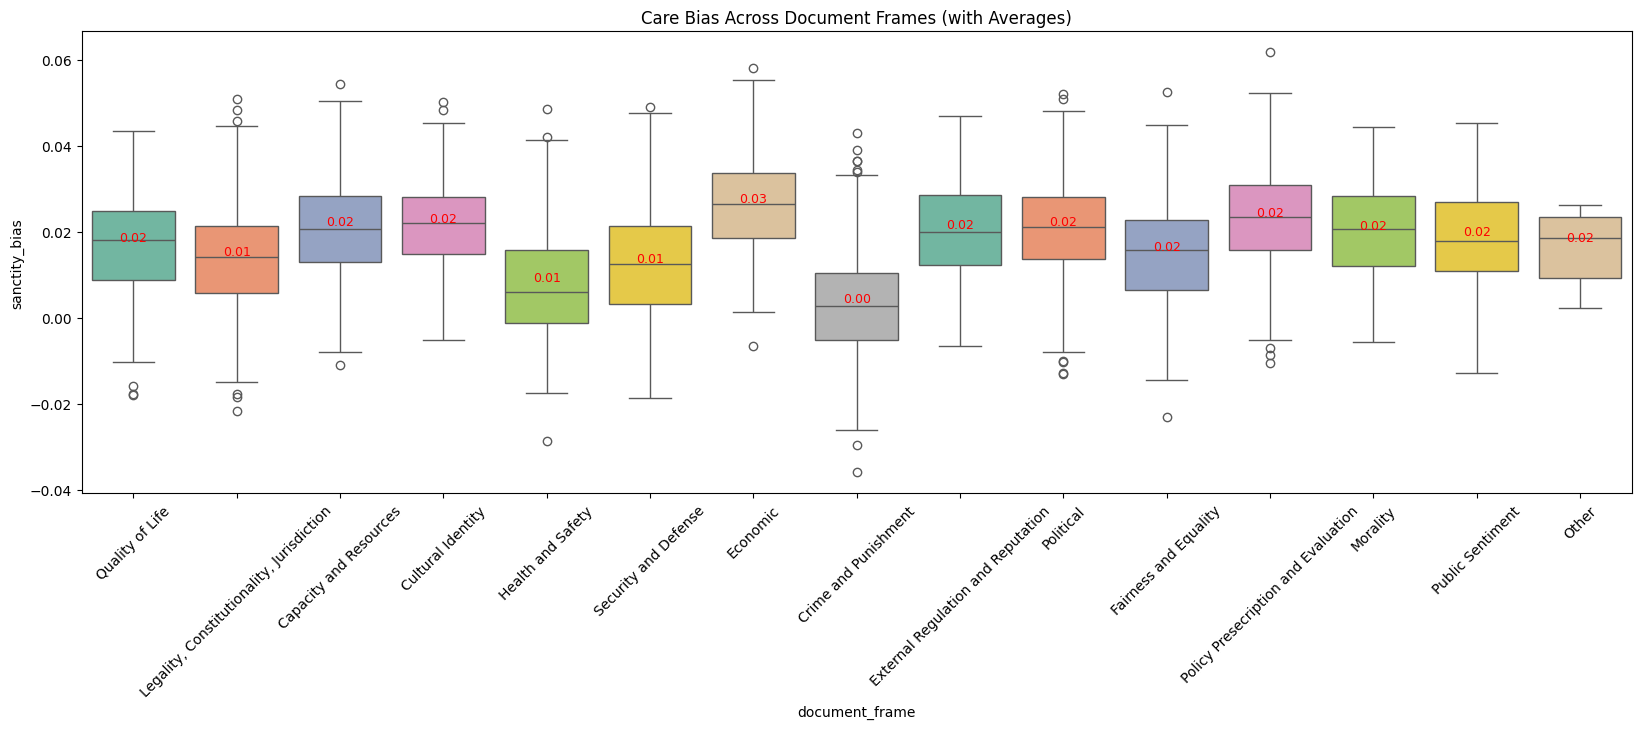

In [69]:
def plot_bias_per_foundation(foundation):
    means = df.groupby('document_frame')[foundation + '_bias'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(20, 6))
    ax = sns.boxplot(x='document_frame', y=foundation + '_bias', data=df, palette='Set2')
    plt.title('Care Bias Across Document Frames (with Averages)')

    # Annotating each box with the mean value
    for i, frame in enumerate(ax.get_xticklabels()):
        frame = frame.get_text()
        mean_val = means.loc[means['document_frame'] == frame, foundation + '_bias'].values[0]
        plt.text(i, mean_val, f'{mean_val:.2f}', fontsize=9, ha='center', va='bottom', color='red')

    plt.xticks(rotation=45)
    plt.show()

plot_bias_per_foundation('care')
plot_bias_per_foundation('loyalty')
plot_bias_per_foundation('authority')
plot_bias_per_foundation('fairness')
plot_bias_per_foundation('sanctity')

C:\Users\elias\AppData\Local\Temp\ipykernel_28424\1702331922.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_intensity', data=df, palette='Set2')


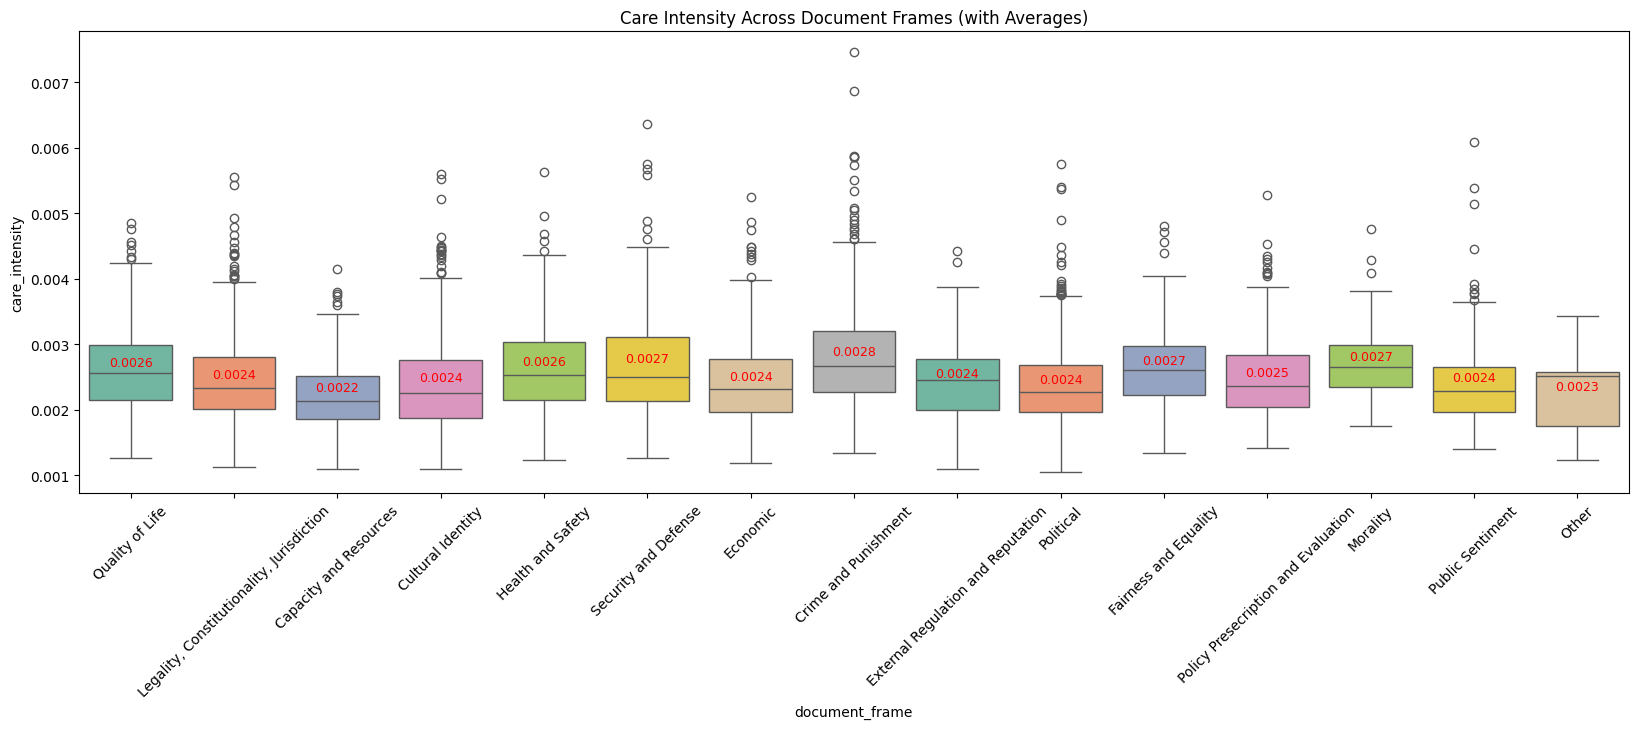

C:\Users\elias\AppData\Local\Temp\ipykernel_28424\1702331922.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_intensity', data=df, palette='Set2')


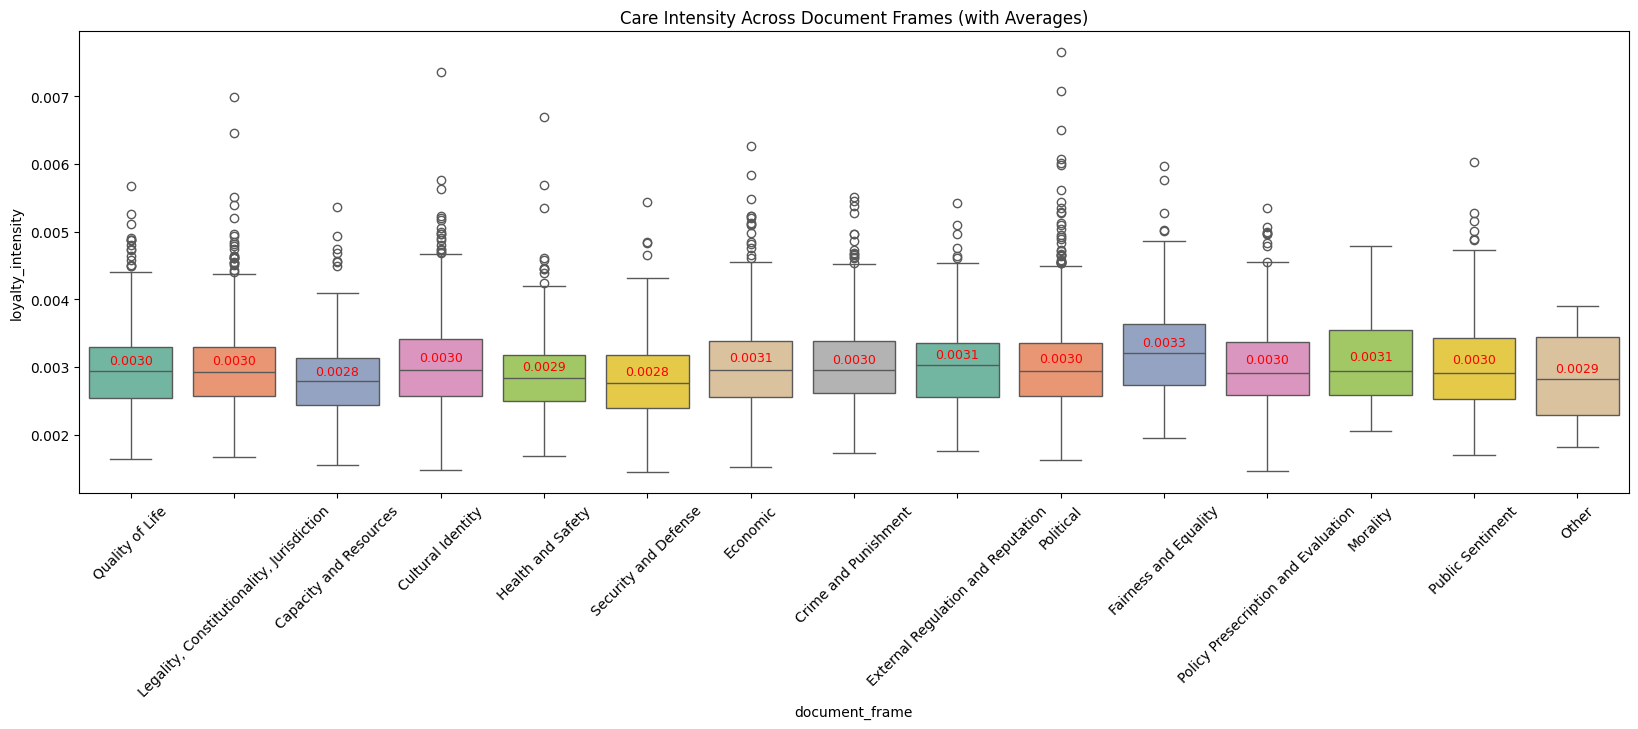

C:\Users\elias\AppData\Local\Temp\ipykernel_28424\1702331922.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_intensity', data=df, palette='Set2')


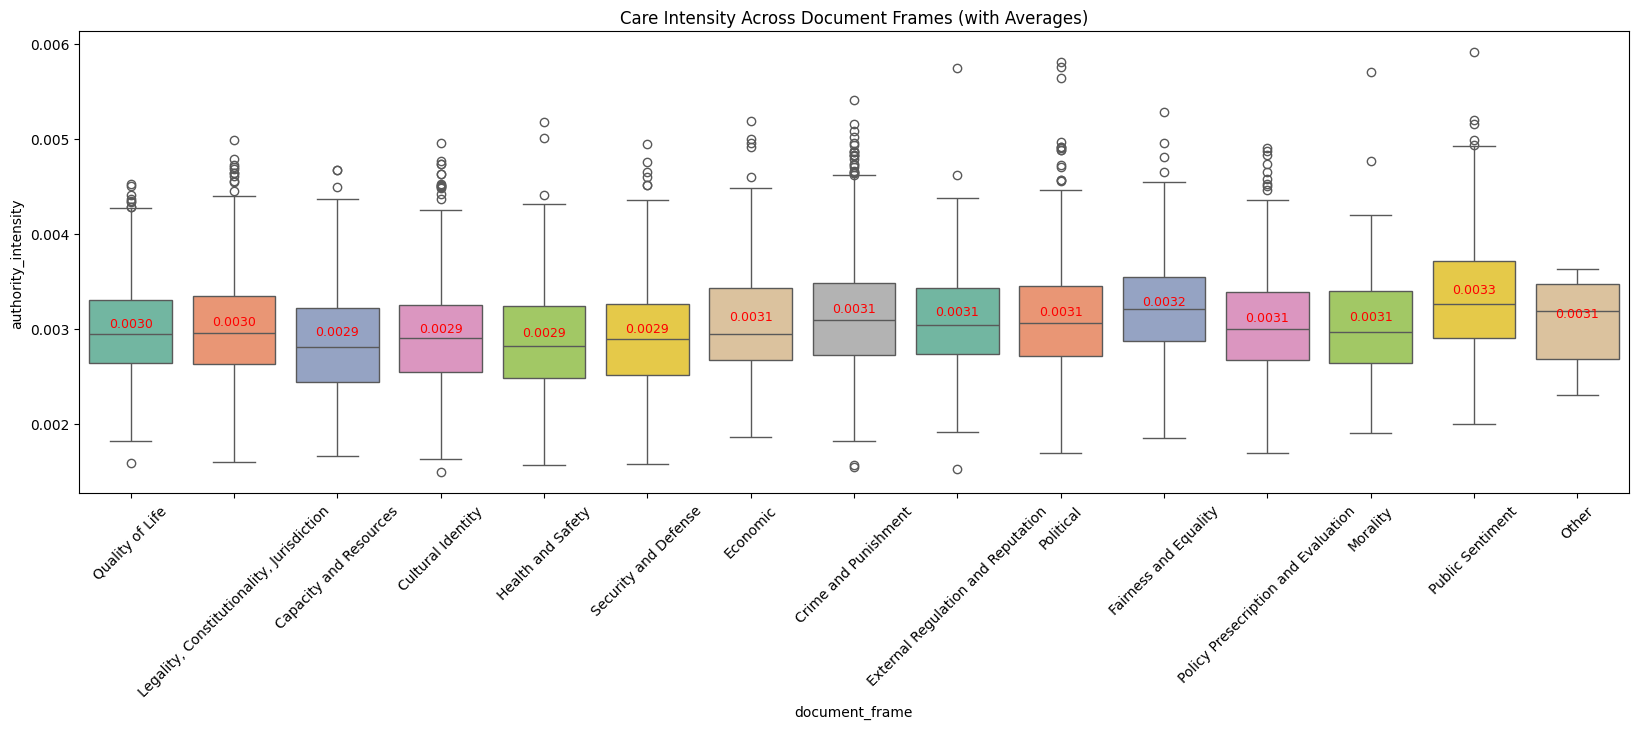

C:\Users\elias\AppData\Local\Temp\ipykernel_28424\1702331922.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_intensity', data=df, palette='Set2')


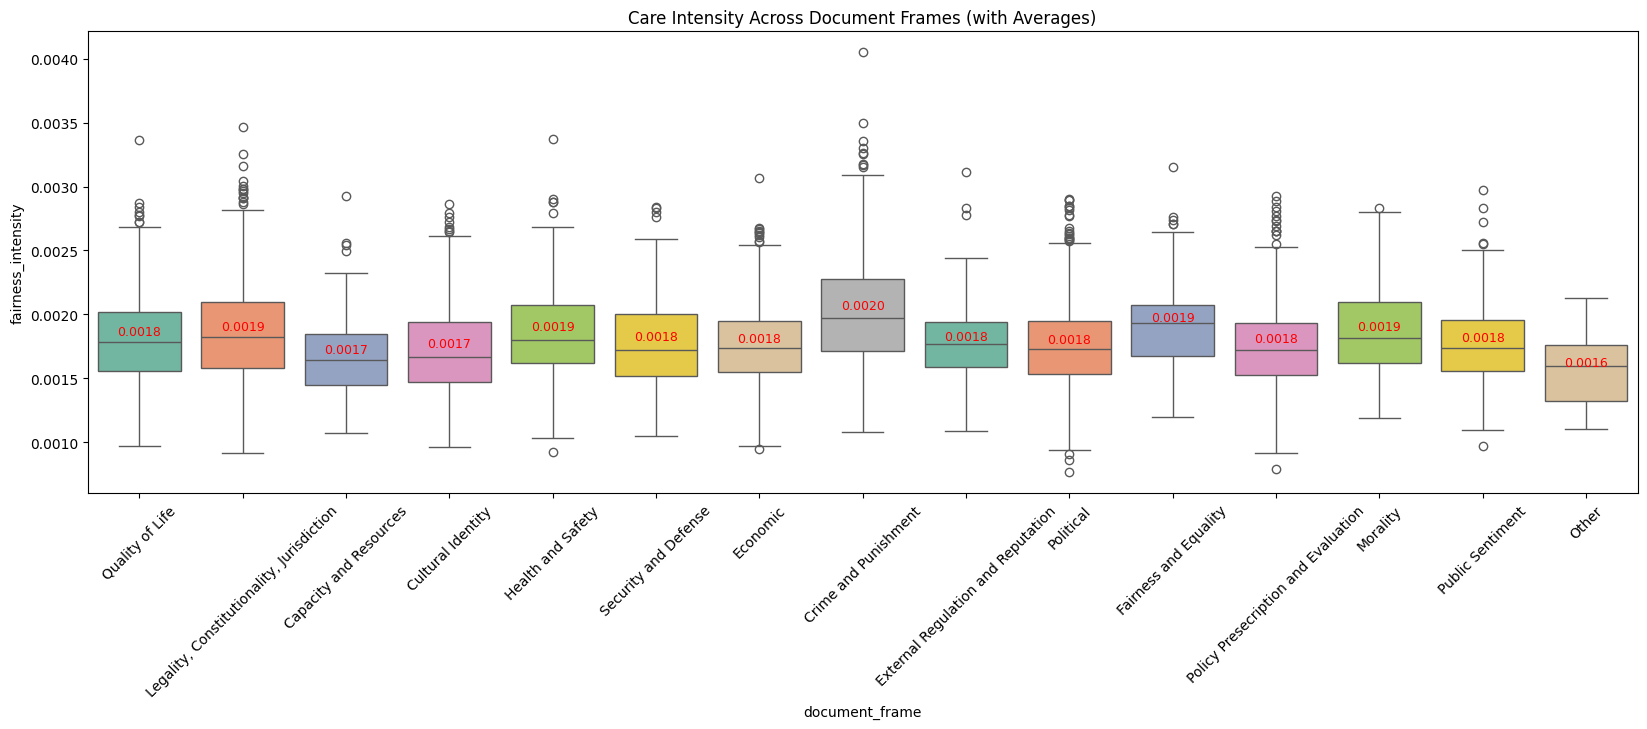

C:\Users\elias\AppData\Local\Temp\ipykernel_28424\1702331922.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_intensity', data=df, palette='Set2')


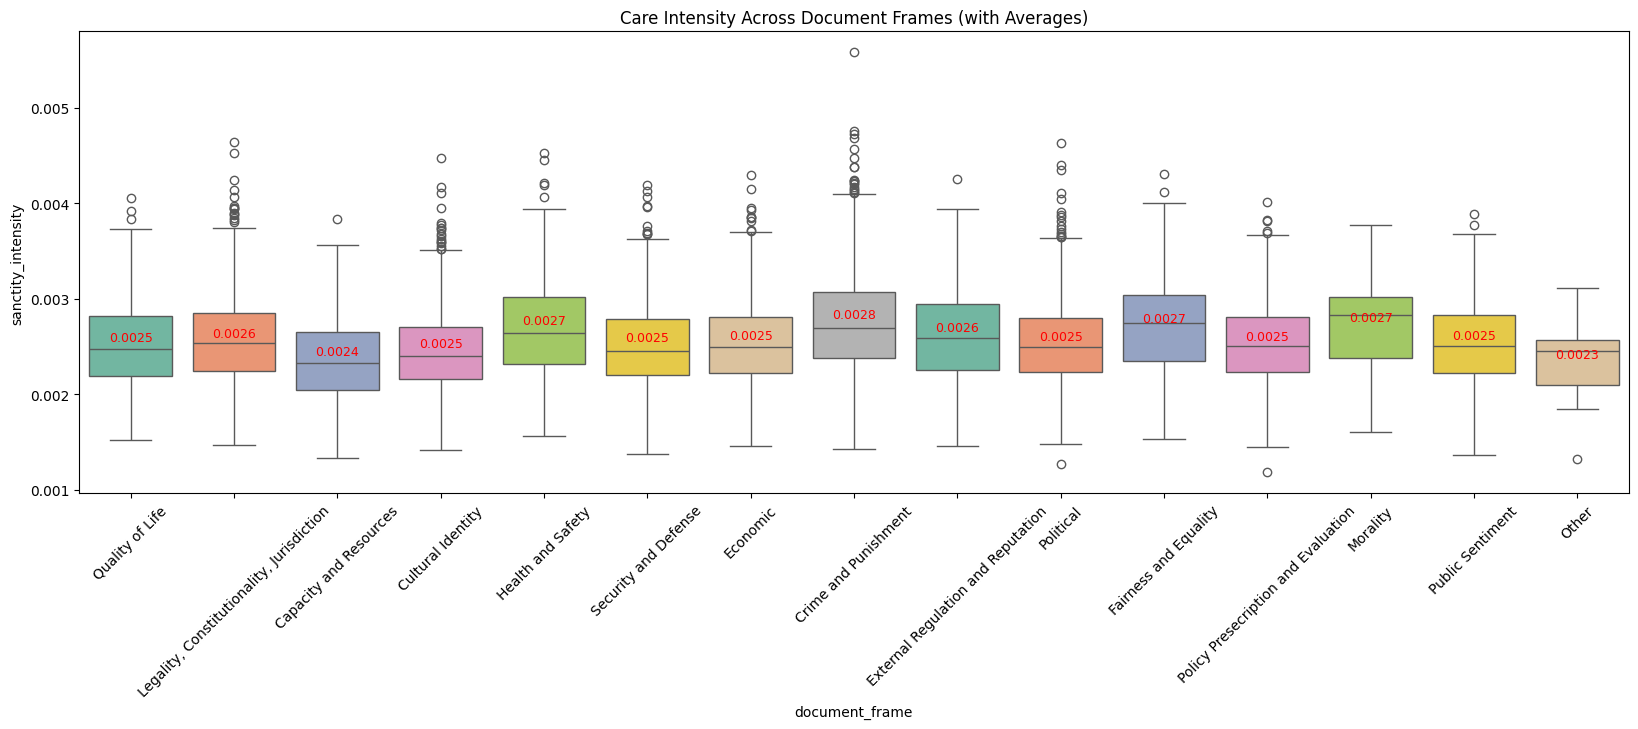

In [70]:
def plot_intensity_per_foundation(foundation):
    means = df.groupby('document_frame')[foundation + '_intensity'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(20, 6))
    ax = sns.boxplot(x='document_frame', y=foundation + '_intensity', data=df, palette='Set2')
    plt.title('Care Intensity Across Document Frames (with Averages)')

    # Annotating each box with the mean value
    for i, frame in enumerate(ax.get_xticklabels()):
        frame = frame.get_text()
        mean_val = means.loc[means['document_frame'] == frame, foundation + '_intensity'].values[0]
        plt.text(i, mean_val, f'{mean_val:.4f}', fontsize=9, ha='center', va='bottom', color='red')

    plt.xticks(rotation=45)
    plt.show()

plot_intensity_per_foundation('care')
plot_intensity_per_foundation('loyalty')
plot_intensity_per_foundation('authority')
plot_intensity_per_foundation('fairness')
plot_intensity_per_foundation('sanctity')

### Plot Bias as X and Intensity as Y axis

In [71]:
# find text which includes: "BILL ON IMMIGRANT WORKERS"
df_merged[df_merged['text'].str.contains("BILL ON IMMIGRANT WORKERS")]

,article_id,authority_bias,authority_intensity,care_bias,care_intensity,fairness_bias,fairness_intensity,loyalty_bias,loyalty_intensity,sanctity_bias,sanctity_intensity,text,document_frame,tone,frame_tone
48313,Immigration1.0-5807,0.091395,0.002923,0.12267,0.002368,-0.010339,0.001658,-0.074202,0.002751,0.022085,0.00298,BILL ON IMMIGRANT WORKERS DIES Legislation to ...,Political,neutral,Political - neutral


In [72]:
idx = 541

authority_example_value = {
    "x": df_merged.iloc[idx]["authority_bias"],
    "y": df_merged.iloc[idx]["authority_intensity"],
    "label": df_merged.iloc[idx]["article_id"] + " - " + df_merged.iloc[idx]["frame_tone"],
}

care_example_value = {
    "x": df_merged.iloc[idx]["care_bias"],
    "y": df_merged.iloc[idx]["care_intensity"],
    "label": df_merged.iloc[idx]["article_id"] + " - " + df_merged.iloc[idx]["frame_tone"],
}

fairness_example_value = {
    "x": df_merged.iloc[idx]["fairness_bias"],
    "y": df_merged.iloc[idx]["fairness_intensity"],
    "label": df_merged.iloc[idx]["article_id"] + " - " + df_merged.iloc[idx]["frame_tone"],
}

loyalty_example_value = {
    "x": df_merged.iloc[idx]["loyalty_bias"],
    "y": df_merged.iloc[idx]["loyalty_intensity"],
    "label": df_merged.iloc[idx]["article_id"] + " - " + df_merged.iloc[idx]["frame_tone"],
}

sanctity_example_value = {
    "x": df_merged.iloc[idx]["sanctity_bias"],
    "y": df_merged.iloc[idx]["sanctity_intensity"],
    "label": df_merged.iloc[idx]["article_id"] + " - " + df_merged.iloc[idx]["frame_tone"],
}

# print full text
print(df_merged.iloc[idx]["text"])

df_merged.iloc[idx]

"Most illegal immigrants come here for jobs, so we have to look to the workplace," Immigration and Naturalization Service Commissioner Doris Meissner said as she unveiled the pilot project, which could become a blueprint for a national system.


article_id                                           Immigration1.0-1035
authority_bias                                                  0.079193
authority_intensity                                             0.002265
care_bias                                                       0.124578
care_intensity                                                  0.003293
fairness_bias                                                    -0.0137
fairness_intensity                                              0.001004
loyalty_bias                                                   -0.080124
loyalty_intensity                                               0.000744
sanctity_bias                                                   0.008772
sanctity_intensity                                              0.001841
text                   "Most illegal immigrants come here for jobs, s...
document_frame                                    Capacity and Resources
tone                                               

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting example point: Immigration1.0-1035 - Capacity and Resources - anti at (0.079192784038328, 0.0022649883921141037)


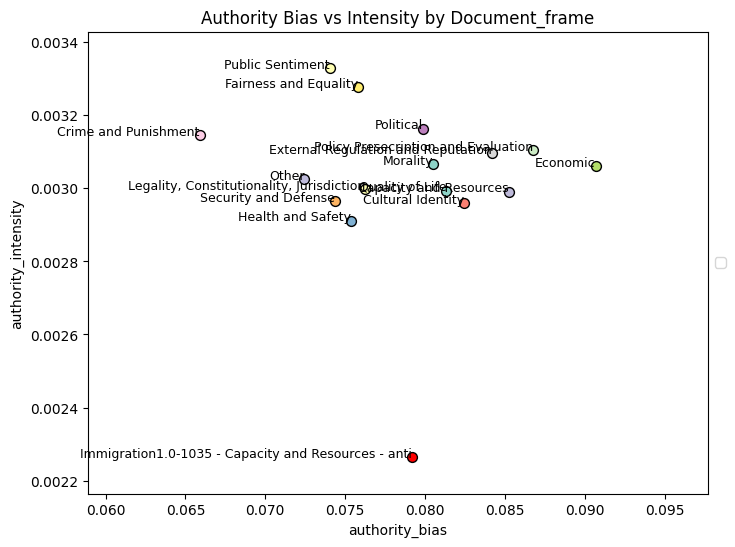

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting example point: Immigration1.0-1035 - Capacity and Resources - anti at (0.12457838379556224, 0.0032928297649162525)


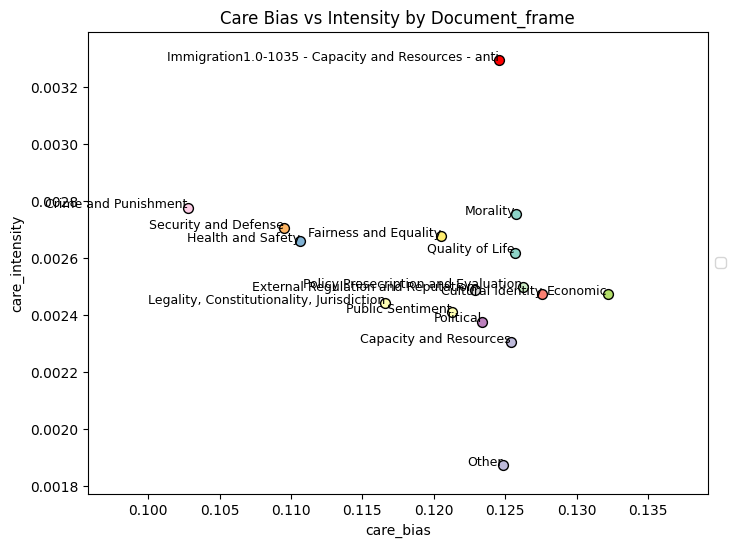

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting example point: Immigration1.0-1035 - Capacity and Resources - anti at (-0.01369981159500423, 0.0010037210389215736)


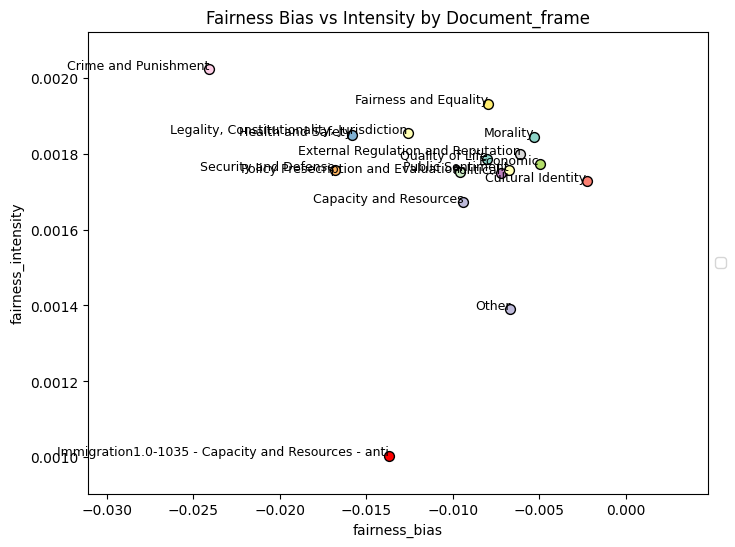

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting example point: Immigration1.0-1035 - Capacity and Resources - anti at (-0.08012426076900392, 0.0007439244318415113)


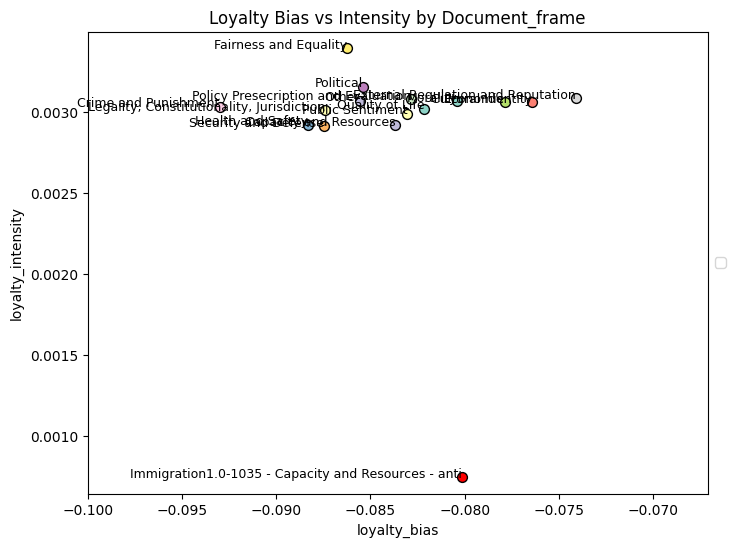

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting example point: Immigration1.0-1035 - Capacity and Resources - anti at (0.008772256118910653, 0.0018408636522853667)


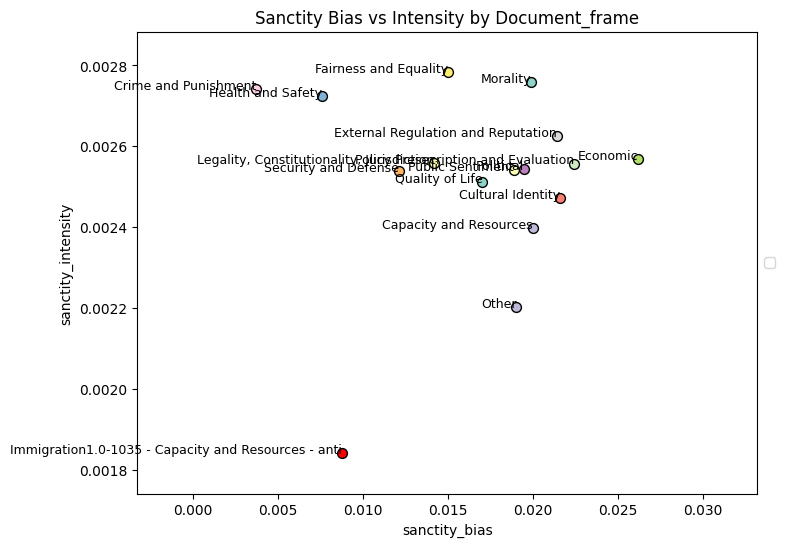

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_pair(df, pair, group_by=['frame_tone'], plot_density={}, tones=['pro', 'anti'], example_plot_value={}):
    # Filter the DataFrame for the tones we are interested in
    df_filtered = df[df['tone'].isin(tones)]
    
    # Set up plot
    plt.figure(figsize=(8, 6))
    
    # List to store points and their labels for later plotting
    points_with_labels = []

    # Iterate over each group type
    for group_type in group_by:
        if group_type in df.columns:
            # Process each unique group within the group type
            unique_groups = df_filtered[group_type].unique()
            for group_name in unique_groups:
                group_data = df_filtered[df_filtered[group_type] == group_name]
                
                # Calculate average values for the pair
                avg_bias = group_data[f'{pair}_bias'].mean()
                avg_intensity = group_data[f'{pair}_intensity'].mean()
                
                # Save the point and label for plotting
                points_with_labels.append((avg_bias, avg_intensity, group_name))

                # Extract bias and intensity for KDE plot
                bias_values = group_data[f'{pair}_bias']
                intensity_values = group_data[f'{pair}_intensity']

                if plot_density.get(group_type, False):
                    # KDE plot for the group
                    color = sns.color_palette('Set3')[len(points_with_labels) % len(sns.color_palette('Set3'))]
                    sns.kdeplot(x=bias_values, y=intensity_values, cmap=sns.light_palette(color, as_cmap=True),
                                fill=True, thresh=0.8, levels=10, alpha=0.8, bw_adjust=0.5)

    # Plot points and their labels
    for bias, intensity, label in points_with_labels:
        plt.scatter(bias, intensity, color=sns.color_palette('Set3')[points_with_labels.index((bias, intensity, label)) % len(sns.color_palette('Set3'))], s=50, edgecolor='black')
        plt.text(bias, intensity, label, fontsize=9, ha='right')

    if "x" in example_plot_value and "y" in example_plot_value and "label" in example_plot_value:
        print(f"Plotting example point: {example_plot_value['label']} at ({example_plot_value['x']}, {example_plot_value['y']})")

        points_with_labels.append((example_plot_value["x"], example_plot_value["y"], example_plot_value["label"]))

        # Plot the example point
        plt.scatter(example_plot_value["x"], example_plot_value["y"], color='red', s=50, edgecolor='black')
        plt.text(example_plot_value["x"], example_plot_value["y"], example_plot_value["label"], fontsize=9, ha='right')

    # Adjusting plot limits to fit all points comfortably
    plt.xlim([min([p[0] for p in points_with_labels]) - 0.007, max([p[0] for p in points_with_labels]) + 0.007])
    plt.ylim([min([p[1] for p in points_with_labels]) - 0.0001, max([p[1] for p in points_with_labels]) + 0.0001])

    # Add labels and legend
    plt.xlabel(f'{pair}_bias')
    plt.ylabel(f'{pair}_intensity')
    plt.title(f'{pair.capitalize()} Bias vs Intensity by {", ".join(group_by).capitalize()}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show plot
    plt.show()


# Example usage:
plot_pair(df_merged, 'authority', group_by=['document_frame'], plot_density={ 'document_frame': False }, tones=['pro', 'anti'], example_plot_value=authority_example_value)
plot_pair(df_merged, 'care', group_by=['document_frame'], plot_density={ 'document_frame': False}, tones=['pro', 'anti'], example_plot_value=care_example_value)
plot_pair(df_merged, 'fairness', group_by=['document_frame'], plot_density={ 'document_frame': False}, tones=['pro', 'anti'], example_plot_value=fairness_example_value)
plot_pair(df_merged, 'loyalty', group_by=['document_frame'], plot_density={ 'document_frame': False}, tones=['pro', 'anti'], example_plot_value=loyalty_example_value)
plot_pair(df_merged, 'sanctity', group_by=['document_frame'], plot_density={ 'document_frame': False}, tones=['pro', 'anti'], example_plot_value=sanctity_example_value)

### Plot Pair for single document_frame

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting example point: Immigration1.0-1035 - Capacity and Resources - anti at (0.079192784038328, 0.0022649883921141037)


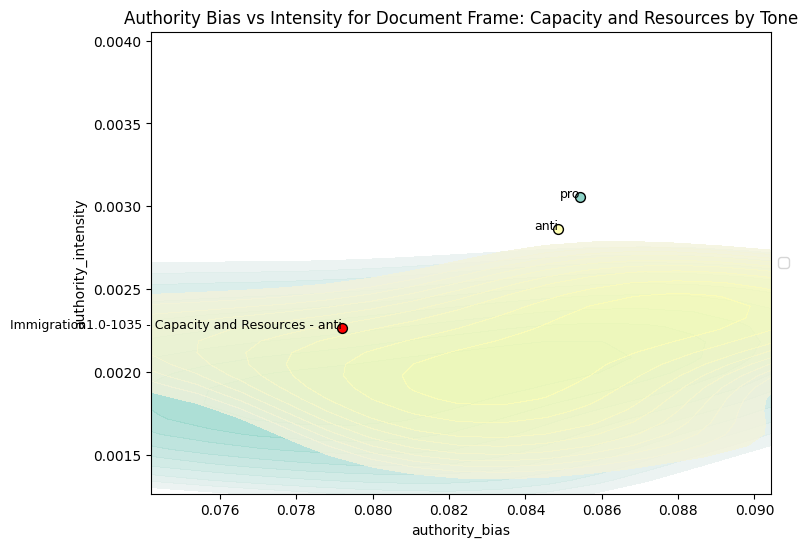

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting example point: Immigration1.0-1035 - Capacity and Resources - anti at (0.12457838379556224, 0.0032928297649162525)


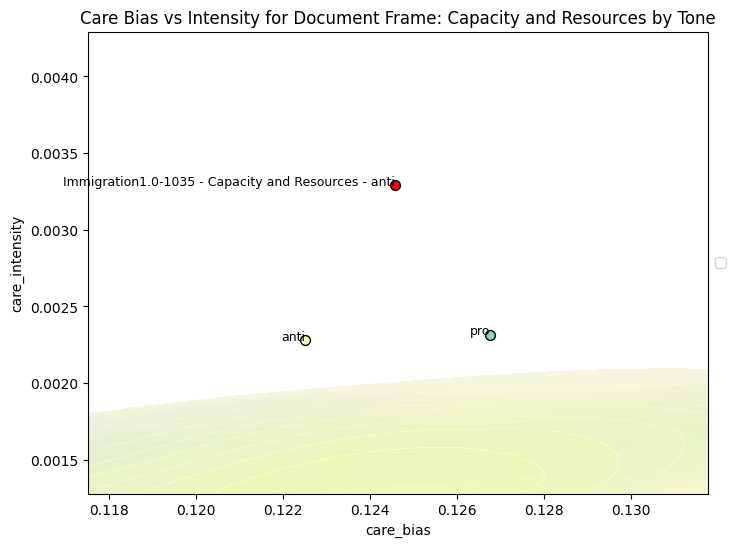

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting example point: Immigration1.0-1035 - Capacity and Resources - anti at (-0.01369981159500423, 0.0010037210389215736)


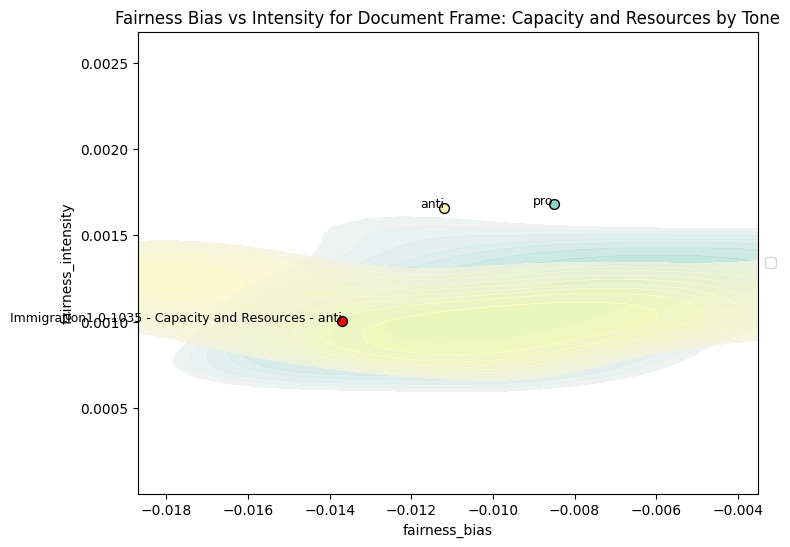

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting example point: Immigration1.0-1035 - Capacity and Resources - anti at (-0.08012426076900392, 0.0007439244318415113)


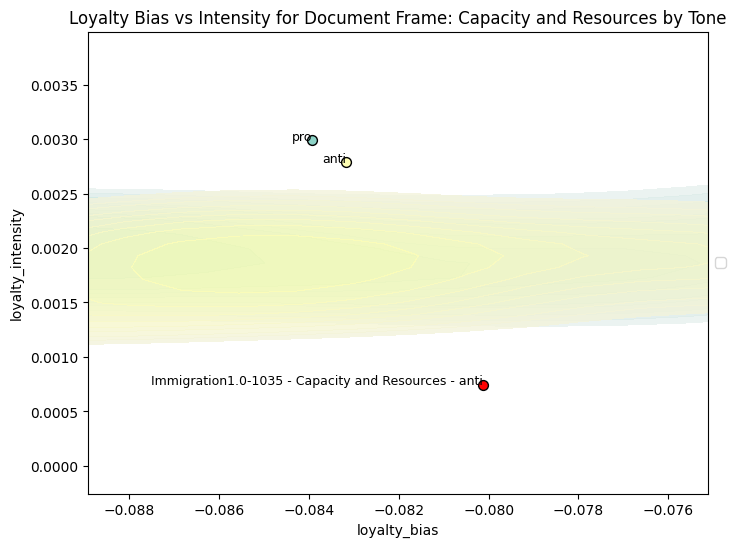

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting example point: Immigration1.0-1035 - Capacity and Resources - anti at (0.008772256118910653, 0.0018408636522853667)


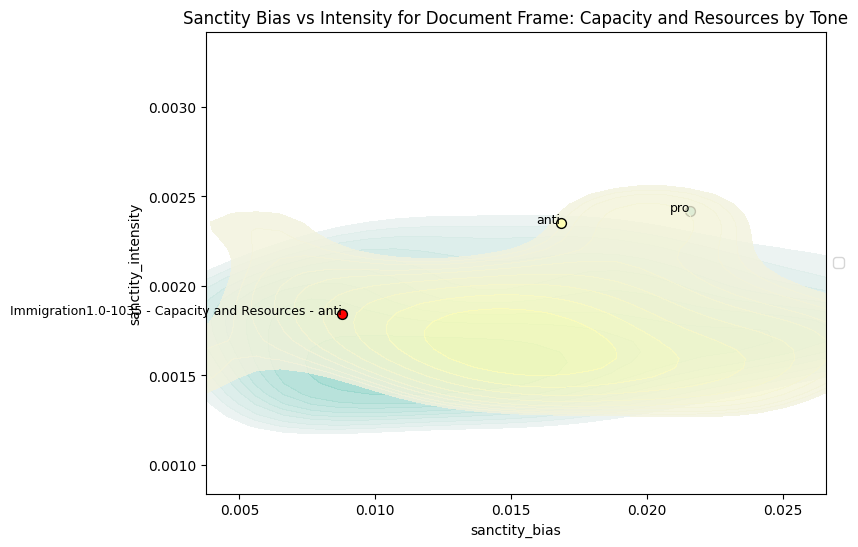

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pair_by_tone_within_frame(df, pair, document_frame, plot_density=True, tones=['pro', 'anti'], example_plot_value={}):
    # Filter the DataFrame for the specified document frame
    df_filtered = df[df['document_frame'] == document_frame]
    
    # Set up plot
    plt.figure(figsize=(8, 6))
    
    # Initialize a list to keep track of points for plot limits
    points_with_labels = []

    # Iterate over each specified tone within the document frame
    for tone in tones:
        tone_data = df_filtered[df_filtered['tone'] == tone]
        
        # Calculate average values for the pair
        avg_bias = tone_data[f'{pair}_bias'].mean()
        avg_intensity = tone_data[f'{pair}_intensity'].mean()
        
        # Save the average point and label for plotting
        points_with_labels.append((avg_bias, avg_intensity, tone))
        
        # Extract bias and intensity for KDE plot if required
        bias_values = tone_data[f'{pair}_bias']
        intensity_values = tone_data[f'{pair}_intensity']

        if plot_density:
            # KDE plot for the tone
            color = sns.color_palette('Set3')[tones.index(tone) % len(sns.color_palette('Set3'))]  # Color by tone index
            sns.kdeplot(x=bias_values, y=intensity_values, cmap=sns.light_palette(color, as_cmap=True),
                        fill=True, thresh=0.8, levels=10, alpha=0.8, bw_adjust=0.5)

        # Plot the average point and label
        plt.scatter(avg_bias, avg_intensity, color=color, s=50, edgecolor='black')
        plt.text(avg_bias, avg_intensity, tone, fontsize=9, ha='right')

    if "x" in example_plot_value and "y" in example_plot_value and "label" in example_plot_value:
        print(f"Plotting example point: {example_plot_value['label']} at ({example_plot_value['x']}, {example_plot_value['y']})")
        points_with_labels.append((example_plot_value["x"], example_plot_value["y"], example_plot_value["label"]))

        # Plot the example point
        plt.scatter(example_plot_value["x"], example_plot_value["y"], color='red', s=50, edgecolor='black')
        plt.text(example_plot_value["x"], example_plot_value["y"], example_plot_value["label"], fontsize=9, ha='right')

    # Adjusting plot limits to fit all points comfortably
    plt.xlim([min([p[0] for p in points_with_labels]) - 0.005, max([p[0] for p in points_with_labels]) + 0.005])
    plt.ylim([min([p[1] for p in points_with_labels]) - 0.001, max([p[1] for p in points_with_labels]) + 0.001])

    # Add labels and legend
    plt.xlabel(f'{pair}_bias')
    plt.ylabel(f'{pair}_intensity')
    plt.title(f'{pair.capitalize()} Bias vs Intensity for Document Frame: {document_frame} by Tone')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show plot
    plt.show()


# Example usage:
plot_pair_by_tone_within_frame(df_merged, 'authority', document_frame='Capacity and Resources', tones=['pro', 'anti'], example_plot_value=authority_example_value)
plot_pair_by_tone_within_frame(df_merged, 'care', document_frame='Capacity and Resources', tones=['pro', 'anti'], example_plot_value=care_example_value)
plot_pair_by_tone_within_frame(df_merged, 'fairness', document_frame='Capacity and Resources', tones=['pro', 'anti'], example_plot_value=fairness_example_value)
plot_pair_by_tone_within_frame(df_merged, 'loyalty', document_frame='Capacity and Resources', tones=['pro', 'anti'], example_plot_value=loyalty_example_value)
plot_pair_by_tone_within_frame(df_merged, 'sanctity', document_frame='Capacity and Resources', tones=['pro', 'anti'], example_plot_value=sanctity_example_value)

### OLD - NEEDS TO BE UPDATES > Evaluate raw frameaxis data

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pickle
import io
import torch

In [ ]:
antonym_pkl_path = "../../data/frameaxis/mfc/frameaxis_antonym_embeddings.pkl"
word_contributions_pkl_path = "../../data/frameaxis/mfc/frameaxis_word_contributions_new.pkl"

Custom unpickler to unpickle the tensors and move from CUDA to CPU.

In [ ]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [ ]:
# read antonym embeddings and word contributions
with open(antonym_pkl_path, 'rb') as f:
    # Load the tensor directly to CPU
    antonym_embeddings = CPU_Unpickler(f).load()

with open(word_contributions_pkl_path, 'rb') as f:
    # Load the tensor directly to CPU
    word_contributions = CPU_Unpickler(f).load()

In [ ]:
# drop 'Capacity and Resources',
#       'Crime and Punishment', 'Cultural Identity', 'Economic',
#       'External Regulation and Reputation', 'Fairness and Equality',
#       'Health and Safety', 'Legality, Constitutionality, Jurisdiction',
#       'Morality', 'Other', 'Policy Prescription and Evaluation', 'Political',
#       'Public Sentiment', 'Quality of Life', 'Security and Defense' cols

drop_columns = [
    "Capacity and Resources",
    "Crime and Punishment",
    "Cultural Identity",
    "Economic",
    "External Regulation and Reputation",
    "Fairness and Equality",
    "Health and Safety",
    "Legality, Constitutionality, Jurisdiction",
    "Morality",
    "Other",
    "Policy Prescription and Evaluation",
    "Political",
    "Public Sentiment",
    "Quality of Life",
    "Security and Defense",
]

word_contributions = word_contributions.drop(columns=drop_columns)

In [ ]:
id1 = 0
id2 = 136

In [ ]:
example1 = next((item for item in word_contributions.iloc[id1]["word_contributions"] if item['word'] == 'immigrants'), None)

example2 = next((item for item in word_contributions.iloc[id2]["word_contributions"] if item['word'] == 'immigrants'), None)

In [357]:
# primary frame 
frame_example1 = word_contributions.iloc[id1]["document_frame"]
frame_example2 = word_contributions.iloc[id2]["document_frame"]

frame_example1, frame_example2

('Quality of Life', 'Crime and Punishment')

In [358]:
# compare the word contributions element-wise
for key in example1.keys():
    if isinstance(example1[key], str):
        print(key)
    else: 
        print(key, example1[key], example2[key], "diff:", (example1[key] - example2[key]))

word
authority 0.010471118614077568 0.08928743004798889 diff: -0.07881631143391132
care 0.126703679561615 0.08790536224842072 diff: 0.038798317313194275
fairness -0.04266376793384552 0.0087781623005867 diff: -0.05144193023443222
loyalty -0.15657886862754822 -0.06754086166620255 diff: -0.08903800696134567
sanctity 0.01058126986026764 0.09922228753566742 diff: -0.08864101767539978


In [359]:
# find article with "Immigrants" in text

max_finds = 3

for idx, row in word_contributions.iterrows():
    if "Immigrants" in row["text"]:
        print(idx, "-", row["text"])
        max_finds -= 1

    if max_finds == 0:
        break

0 - Immigrants without HOPE need help entering college Anxiety gripped Jose Alvarado in third-period calculus class at North Atlanta High School.
136 - City Seeks to Prevent Swindling of Immigrants Over Visa Lottery The New York City Department of Consumer Affairs said yesterday that it would seek to steer immigrants from unscrupulous businesses that claim to help them in a lottery for visas.
169 - No Amnesty For Illegal Immigrants E. Patrick McGuire, in criticizing President Bush's amnesty proposal for illegal immigrants from Mexico [letters, July 21], might have also mentioned the work of hundreds of dedicated American Foreign Service professionals.


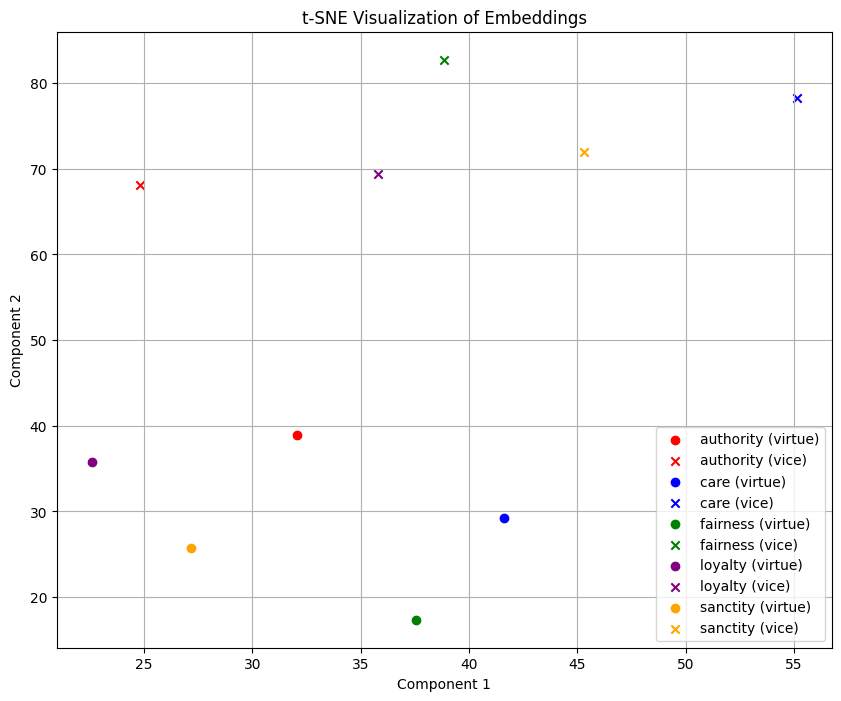

In [398]:
embeddings = []
labels = []
colors = {
    'authority': 'red', 'care': 'blue', 'fairness': 'green',
    'loyalty': 'purple', 'sanctity': 'orange'
}
markers = {'vice': 'x', 'virtue': 'o'}

for foundation, values in antonym_embeddings.items():
    for type, embedding in values.items():
        embeddings.append(embedding)
        labels.append((foundation, type))

# Convert list of tensors to a tensor
embeddings_tensor = torch.stack(embeddings)

# Calculate pairwise cosine similarity (optional)
similarity_matrix = torch.nn.functional.cosine_similarity(embeddings_tensor.unsqueeze(0), embeddings_tensor.unsqueeze(1), dim=2)

# Convert the tensor to numpy for sklearn operations
embeddings_np = embeddings_tensor.numpy()

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, perplexity=5, learning_rate='auto', n_iter=3000, random_state=42)
embeddings_reduced = tsne.fit_transform(embeddings_np)

# Plotting
plt.figure(figsize=(10, 8))
for (x, y), (foundation, type) in zip(embeddings_reduced, labels):
    plt.scatter(x, y, color=colors[foundation], marker=markers[type], label=f'{foundation} ({type})')

# To avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()